In [1]:
import numpy as np 
import matplotlib.pyplot as plt
from scipy import *
import scipy as scipy

In [2]:
from qutip import *

# Parameters

In [3]:
import pylab as plot
params = {'legend.fontsize': 15,
          'legend.handlelength': 2}
plot.rcParams.update(params)

# Single Mode Qubit

## Class

In [85]:
class circ_grape: 
    def __init__(self, n_q=2, n_c=30, param = {'chi1' : 2 * np.pi * 200 * 1e-6, # in units of Ghz
                                     #'chi2' : 2 * np.pi * 240 * 1e-6,
                                     'alpha1' : 10 ,
                                     'alpha2' : 10,
                                     'del_c1' : 2 * np.pi * 10 * 1e-3,  # Cavity drive detunings 
                                     #'del_c2' : 2 * np.pi * 10 * 1e-3,
                                     'Omega_q' :2 * np.pi * 10 * 1e-3,
                                     'epsilon': 2 * np.pi * 100 * 1e-3,
                                     'Kq': 2 * np.pi * 0.1}): 
        self.n_q = n_q
        self.n_c = n_c
        self.init_operators_and_states()
        self.param = param
        self.H = None
        self.times = None


    def init_operators_and_states(self):
        #qutip ops
        # Creating identity, annhilitation/creation, num operators 
        self.identity_q = qeye(self.n_q)
        self.identity_c = qeye(self.n_c)

        self.a_q = destroy(self.n_q)
        self.a_c = destroy(self.n_c)

        self.adag_q = create(self.n_q)
        self.adag_c = create(self.n_c)

        self.num_q = num(self.n_q)
        self.num_c =  num(self.n_c)

        #nonlinearity
        self.quart_nonlin_q = self.adag_q  * self.adag_q  * self.a_q * self.a_q

        self.plus = (basis(self.n_q, 0 ) + basis(self.n_q, 1)) / np.sqrt(2)
        self.minus = (basis(self.n_q, 0 ) - basis(self.n_q, 1)) / np.sqrt(2)

    """Cavity Drive Functions"""
    def gaussian(self, t, amp = 1, chop = 4, center = 400, sigma = 200):
        '''
        returns a point sampled from a gaussian 
        '''
        ts = np.linspace(-chop / 2 * sigma, chop / 2 * sigma, chop * sigma)
        Ps = amp * np.exp(-((ts)**2) / (2.0 * sigma**2))
        ofs = Ps[0]
        
        p = amp * np.exp(-((t-center)**2) / (2.0 * sigma**2))
        
        p = (p - ofs) / (1 - ofs)
        #print(ofs)
        return p 

    import scipy.integrate

    def norm_gaussian_wave(self, t, omega_d):
        chop = 4
        sigma = int(np.max(t) / chop)
        center = int(np.max(t) / 2)
        # Pass additional arguments to the gaussian function using args
        area = scipy.integrate.quad(self.gaussian, 0, np.max(t), args=(1, chop, center, sigma))[0]
        p = self.gaussian(t, amp=1/area)
        
        return p * np.exp(1.0j * omega_d * t)
    def alpha_from_epsilon_nonlinear_finite_difference(self, epsilon_array, delta=0, alpha_init=0 + 0.0j):
        '''
        Copied from Alec Eickbush ECD

        viewing delta is the "detuning" from the original frame. This new frame is from where 
        we view the dynamics
        '''
        dt = 1
        alpha = np.zeros_like(epsilon_array)
        alpha[0] = alpha_init
        alpha[1] = alpha_init
        for j in range(1, len(epsilon_array) - 1):
            alpha[j + 1] = (
                    2*dt * (
                        -1j * delta * alpha[j] + 
                        - 1j * epsilon_array[j] #* np.exp(-1j* viewing_delta * j*dt)
                        #- 2j * Ks * np.abs(alpha[j]) ** 2 * alpha[j]
                        #- (kappa / 2.0) * alpha[j]
                    )
                    + alpha[j - 1]
                    )
        return alpha
    
    def cavity_drive_perf_disp(self, omega_d = 0, tw = 100, delta = 0):
        '''
        Assume initial cavity displacements are perfect

        Note that this pulse is as viewed in the detuned frame. (this pulse in lab frame is off resonant)
        '''
        alpha = self.param['alpha1']
        wait = np.array([-1 * delta * alpha + 0.0j for _ in range(tw)])
        return wait

    
    def cavity_drive(self, omega_d = 0 , tw = 100, delta = 0, gain_to_alpha = 0):
        '''
        tw is wait time 
        pulse pattern - displace - wait - displace back

        Progress: the initial displacement should be a resonant pulse which should be viewed in the 
        detuned frame with e ^ i Delta t. However, b.c of equation of motion, it does not reach the target alpha. 
        We need to do some kind of optimization (increase amplitude) until |alpha| reaches th target alpha

        gain_to_alpha is present so we can convert gain to frequency in this function 
        '''
        alpha = self.param['alpha1']
        ts = np.linspace(0, 800, 800)
        # delta factor matters as solution is eps/delta
        wave =  1.0j * alpha * self.norm_gaussian_wave(ts, omega_d)
        #if this resonant is viewed in the detuned frame
        wave_exps = np.array([wave[idx] * np.exp(1.0j* delta*ts[idx]) for idx in range(len(wave))])
        alpha0= self.alpha_from_epsilon_nonlinear_finite_difference(wave_exps, delta = delta)[-1] #* np.exp(1.0j * delta * 1)

        # pulse pattern - displace - wait - displace back
        disp =  wave_exps.copy()
        #wait = np.array([-1 * delta * alpha0 for _ in range(tw)])
        #disp_back =  wave.copy() * -1 * np.exp(-1.0j * delta * ( len(disp)))
        #on back pulse, the exponential factor (since wave is resonant viewed in detuned frame) needs to take account of time of whole pulse
        #disp_back = -1* np.array([wave[idx] * np.exp(1.0j* delta*( ts[idx])) for idx in range(len(wave))]) * np.exp(-1.0j * delta * ( len(disp)))
        pulse = disp#np.concatenate((disp))#, wait, disp_back))

        print('Gain to alpha: ', gain_to_alpha)
        print('Gain to frequency (in kHz): %.5f ' % (gain_to_alpha *  np.abs(max(wave)) / self.param['alpha1']  * 1e6))
        return pulse 

        
    
    def solve_master(self, times = None, init = None): 
        '''
        solve master equation
        '''
        if self.times is None: 
            self.times = times
        opts = Options(store_states=True, store_final_state=True, nsteps = 10000)
        self.output = mesolve(self.H, init , self.times, [], [], options =opts) 

    def get_fidelity(self, state, target) : 
        def dot( state1, state2):
                '''
                dotting both states
                '''
                fid = state1.overlap(state2)
                return fid*np.conjugate(fid)
            
        if (state.type == 'ket') and (target.type == 'ket'):
            result = dot(state, target)

        elif (state.type == 'oper') and (target.type == 'ket'): #density matrix alert
            target_rho= target*target.dag()
            result = np.sqrt(dot(state, target_rho)) # Hilbert schmidt prod is enough, no need for squaring (try to do this for pure states and you'll get why sqrt used here)
        return result


    def plot_populations_single_mode(self, figname= None, title= None):
        '''
        Given output of mesolve, outputs populations with qubit as ground
        '''
        output_states = self.output.states
        
        fig, axs = plt.subplots(2,1, figsize=(10,8))
        probs = []
        times = self.times
        max_num_levels = 10 # to be shown on the plot
        
        #qubit grounded
        for i in range(max_num_levels):
            target = tensor(basis(self.n_q,0), basis(self.n_c, i))
            pops = []
            for k in range(len(output_states)): 
                z = target.overlap(output_states[k])
                pops.append(z.real**2 + z.imag**2)
            axs[0].plot(times * 1e-3, pops, label = '|g,'+str(i)+'>')
        
        #qubit excited
        for i in range(max_num_levels):
            target = tensor(basis(self.n_q,1), basis(self.n_c, i))
            pops = []
            for k in range(len(output_states)): 
                z = target.overlap(output_states[k])
                pops.append(z.real**2 + z.imag**2)
            axs[1].plot(times * 1e-3, pops, linestyle = '--',  label = '|e,'+str(i) +'>')

        axs[1].set_xlabel(r"Time ($\mu$s)", fontsize = 18)
        axs[1].set_ylabel("Populations", fontsize = 18)
        axs[0].set_ylabel("Populations", fontsize = 18)
        axs[0].tick_params(axis = 'both', which = 'major', labelsize = '15')
        axs[0].tick_params(axis = 'both', which = 'minor', labelsize = '15')
        axs[1].tick_params(axis = 'both', which = 'major', labelsize = '15')
        axs[1].tick_params(axis = 'both', which = 'minor', labelsize = '15')
    #     axs[0].set_xticks(fontsize= 10)
    #     axs[1].set_yticks(fontsize= 10)
    #     axs[0].set_yticks(fontsize= 10)
    #     plt.legend(prop={'size': 20},  fontsize = 8, loc='upper center', bbox_to_anchor=(0.5, 1.05),
    #           ncol=3, fancybox=True, shadow=True)   
        axs[0].legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize = '15')
        axs[1].legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize = '15')
        #plt.legend(fontsize = '15')
        #fig.suptitle(title, fontsize = 15)
        plt.tight_layout()
        #fig.savefig(figname, dpi = 1000)
    def plot_populations_single_mode_plus_minus_basis(self, figname= None, title= None, displace_back = False,
                                                      f_state = False, h_state = False):
        '''
        Given output of mesolve, outputs populations with qubit as plus
        '''
        output_states = self.output.states
        probs = []
        times = self.times
        max_num_levels = 10 # to be shown on the plot
        if displace_back:
            op = tensor(self.identity_q, displace(self.n_c, -1* self.param['alpha1']))
            output_states = [op* state for state in output_states]
        
       # return output_states
        
        q_state_label = ['+', '-', 'f', 'h']
        q_states = [self.plus, self.minus]
        if f_state: 
            q_states.append(basis(self.n_q, 2 ))
        if h_state: 
            q_states.append(basis(self.n_q, 3))
        
        fig, axs = plt.subplots(len(q_states),1, figsize=(10, 4 * len(q_states)))
        
        for idx, q_state in enumerate(q_states): 
            for i in range(max_num_levels):
                target = tensor(q_state, basis(self.n_c, i))
                pops = []
                for k in range(len(output_states)): 
                    z = target.overlap(output_states[k])
                    pops.append(z.real**2 + z.imag**2)
                axs[idx].plot(times*1e-3, pops, label = '|' + q_state_label[idx]+ ','+str(i)+'>')
                
                #formatting 
                axs[idx].tick_params(axis = 'both', which = 'major', labelsize = '15')
                axs[idx].tick_params(axis = 'both', which = 'minor', labelsize = '15')
                axs[idx].legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize = '15')
        axs[-1].set_xlabel(r"Time ($\mu$s)", fontsize = 18)
        axs[0].set_ylabel("Populations", fontsize = 18)
        plt.tight_layout()
        #fig.savefig(figname, dpi = 1000)

## Displaced Frame  + Hadamard Hamiltonian

$$ H =  \Delta_{c} a ^\dagger a  - \Omega_q \sigma_z/2 + \chi \alpha(a^\dagger +a)\sigma_x $$

In [360]:
cg = circ_grape()
cg.param['del_c1'] = 2 * np.pi * 0.01
cg.param['Omega_q'] = 2 * np.pi * 0.01

In [361]:
H0 = (cg.param['del_c1'] *tensor(cg.identity_q, cg.num_c) +
      -1* cg.param['Omega_q'] * tensor(sigmaz(), cg.identity_c)/2  + 
     cg.param['chi1'] * cg.param['alpha1'] * tensor(sigmax(), cg.a_c + cg.adag_c)
     )
cg.H = [H0]

In [362]:
cg.solve_master(times = np.linspace(0, 2000, 500), 
                init = tensor(basis(cg.n_q,1), basis(cg.n_c,0))
)

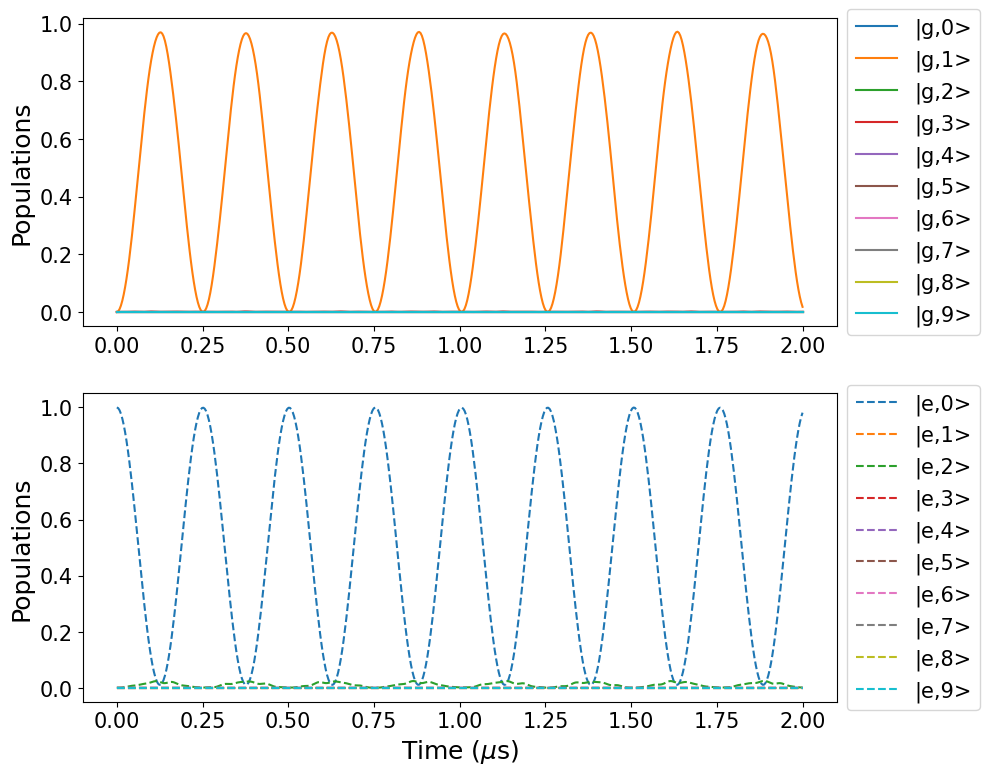

In [363]:
cg.plot_populations_single_mode()

## Displaced Frame  + Hadamard Hamiltonian (Parametric Modulation)

$$ H =  \Delta_{c} a ^\dagger a  - (\Omega_q + \epsilon sin(\Delta t)) \sigma_z/2 + \chi \alpha(a^\dagger +a)\sigma_x $$

In [364]:
cg = circ_grape()
cg.param['del_c1'] = 2 * np.pi * 0.07
cg.param['Omega_q'] = 2 * np.pi * (0.07 -0.054)
cg.param['epsilon'] = 2 * np.pi * 0.1

In [365]:
(cg.param['chi1'] *cg.param['alpha1'])/(2 * np.pi)

0.002

In [366]:
H0 = (cg.param['del_c1'] *tensor(cg.identity_q, cg.num_c) +
      -1* cg.param['Omega_q'] * tensor(sigmaz(), cg.identity_c)/2  + 
     cg.param['chi1'] * cg.param['alpha1'] * tensor(sigmax(), cg.a_c + cg.adag_c)
     )

In [367]:
cg.times = np.linspace(0, 2000, 1000)
Delta = np.abs(cg.param['del_c1'] - cg.param['Omega_q'])
sine = np.array([np.sin(Delta*t) for t in cg.times], dtype = np.single)

cg.H = [H0, 
     [ -1*cg.param['epsilon']*tensor(sigmaz(), cg.identity_c)/2 , sine]
    ]

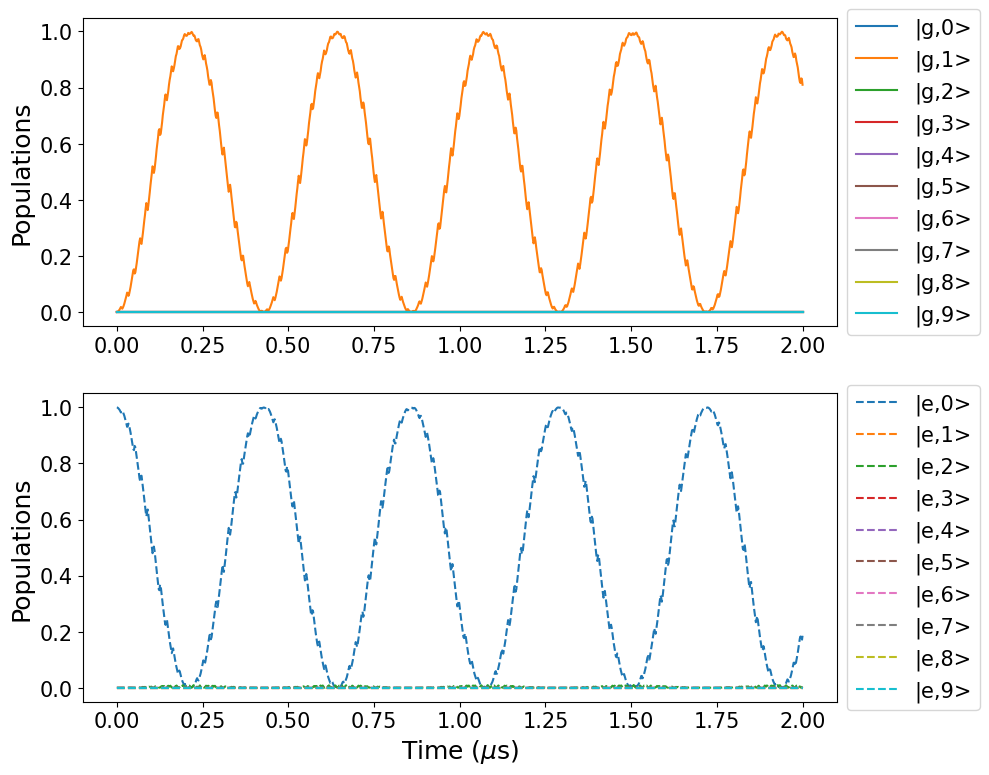

In [368]:
cg.solve_master(init = tensor(basis(cg.n_q,1), basis(cg.n_c,0))
)
cg.plot_populations_single_mode()

Makes sense that the rate seems ~$0.6g$ as the Bessel Function $J_1 (\frac{\epsilon}{\Delta_{c1} - \Omega_q})$ has a maximum of ~0.6

Starting state is g0

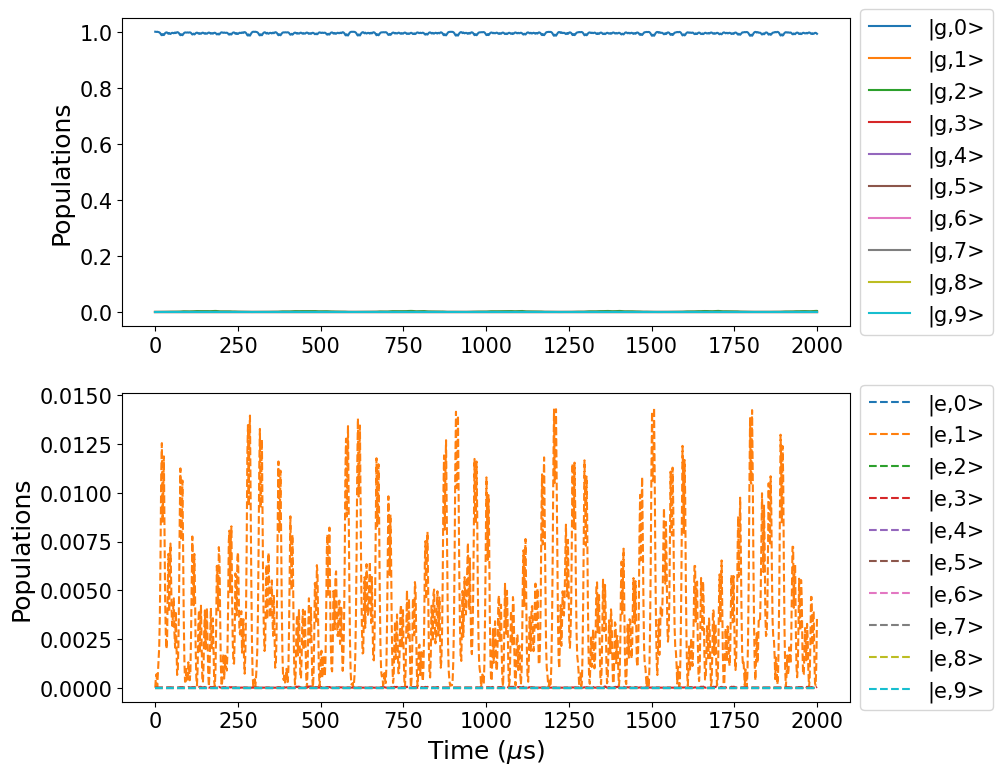

In [54]:
cg.solve_master(init = tensor(basis(cg.n_q,0), basis(cg.n_c,0))
)
cg.plot_populations_single_mode()

#### Sweep over frequencies to produce chevron plot (need to update parameters)

In [178]:
# sweep over frequencies and collect population data of g1 and e0 state
def evolve_and_get_pop(omega):
    '''
    combines state population at the particular modulation frequency and returns pops 
    '''

    
    H0 = (del_c1*tensor(identity_q, num_c) + 
     2*chi1 * alpha1 * tensor(sigmax(), a_c + adag_c)
     )
    c_ops = []

    times = np.linspace(0, 8000, 2000)
    sine = np.array([np.sin(omega*t) for t in times], dtype = np.single)
    
    
    H = [H0, 
         [ -1*epsilon*tensor(sigmaz(), identity_c)/2 , sine]
        ]

    #evolution
    psi0 = tensor(basis(n_q,1), basis(n_c,0))
    opts = Options(store_states=True, store_final_state=True, nsteps = 10000)
    output = mesolve(H, psi0 , times, c_ops, [], options =opts)

    #compute populations 
    targets =[tensor(basis(n_q,1), basis(n_c, 0)), tensor(basis(n_q,0), basis(n_c, 1))]# e0 and g1 
    targ_pops = [[np.abs(target.overlap(output.states[k]))**2 for k in range(len(times))]for target in targets]
    return targ_pops
    

In [193]:
omegas=np.linspace(0.95, 1.05, 50) * del_c1
pops_vs_omega = [evolve_and_get_pop(omega) for omega in omegas]

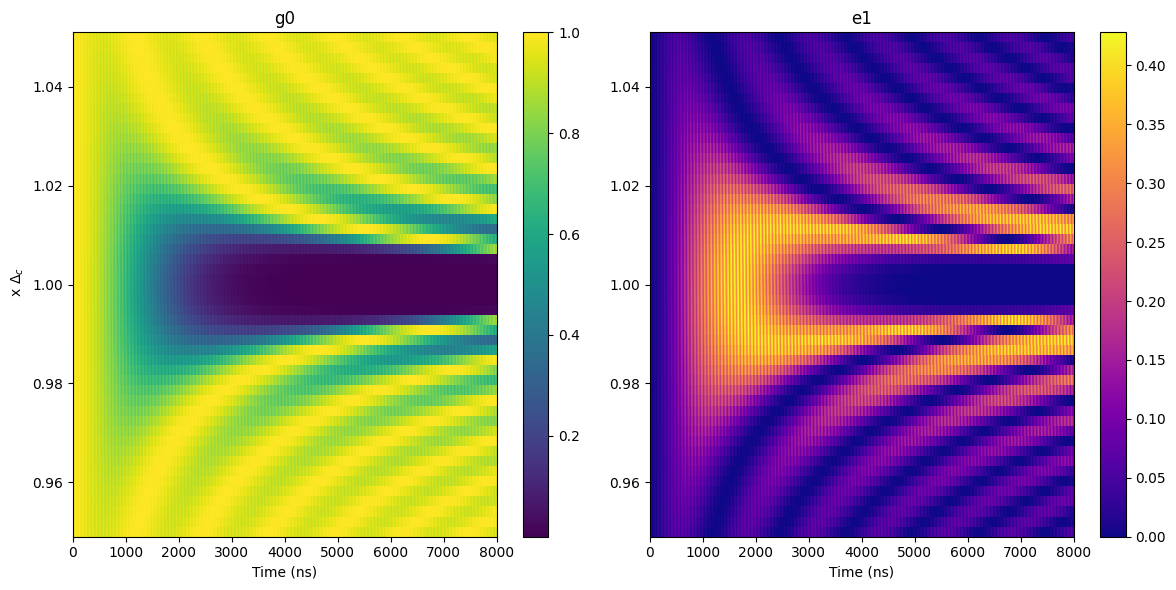

In [197]:
# Generate some random data for demonstration
times = np.linspace(0, 8000, 2000)
x = times
y = omegas/del_c1
X, Y = np.meshgrid(x, y)
Z1 = np.transpose(pops_vs_omega, axes=[1,0,2])[0]
Z2 = np.transpose(pops_vs_omega, axes=[1,0,2])[1]

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot data on the first subplot
pcm1 = axs[0].pcolormesh(X, Y, Z1, cmap='viridis')
axs[0].set_title('g0')
plt.colorbar(pcm1, ax=axs[0])

# Plot data on the second subplot
pcm2 = axs[1].pcolormesh(X, Y, Z2, cmap='plasma')
axs[1].set_title('e1')
axs[1].set_xlabel('Time (ns)')
axs[0].set_xlabel('Time (ns)')
axs[0].set_ylabel(' x $\Delta_c$')
plt.colorbar(pcm2, ax=axs[1])

# Adjust layout
plt.tight_layout()

# Show plots
plt.show()

## Full enhanced dispersive interaction 
$$ H =  \Delta_{c} a ^\dagger a  + \Omega_q \sigma_x/2 - \chi \alpha(a^\dagger + a)\sigma_z  - \chi|\alpha|^2 \sigma_z - \chi a^\dagger a \sigma_z$$

In [91]:
alpha = 5
Omega_q = 0.1
del_c1 = 0.1
#dc_offset = 0.1

H0 = (del_c1*tensor(identity_q, num_c) +
      +1* Omega_q* tensor(sigmax(), identity_c)/2  + 
     -1*chi1 * alpha * tensor(sigmaz(), a_c + adag_c) + 
     -1 * chi1 *  alpha * alpha * tensor(sigmaz(), identity_c)  
     -1 * chi1 * tensor(sigmaz(), num_c)
     )
H = [H0]  
c_ops = []

In [92]:
times = np.linspace(0, 4000, 2000)


plus = (basis(n_q, 0 ) + basis(n_q, 1)) / np.sqrt(2)
psi0 = tensor(plus, basis(n_c,0))
opts = Options(store_states=True, store_final_state=True, nsteps = 10000)
output = mesolve(H, psi0 , times, c_ops, [], options =opts)
states_filename = 'State_store_g0_g1_disp'
qsave(output.states, states_filename)
rho = output.states[-1]

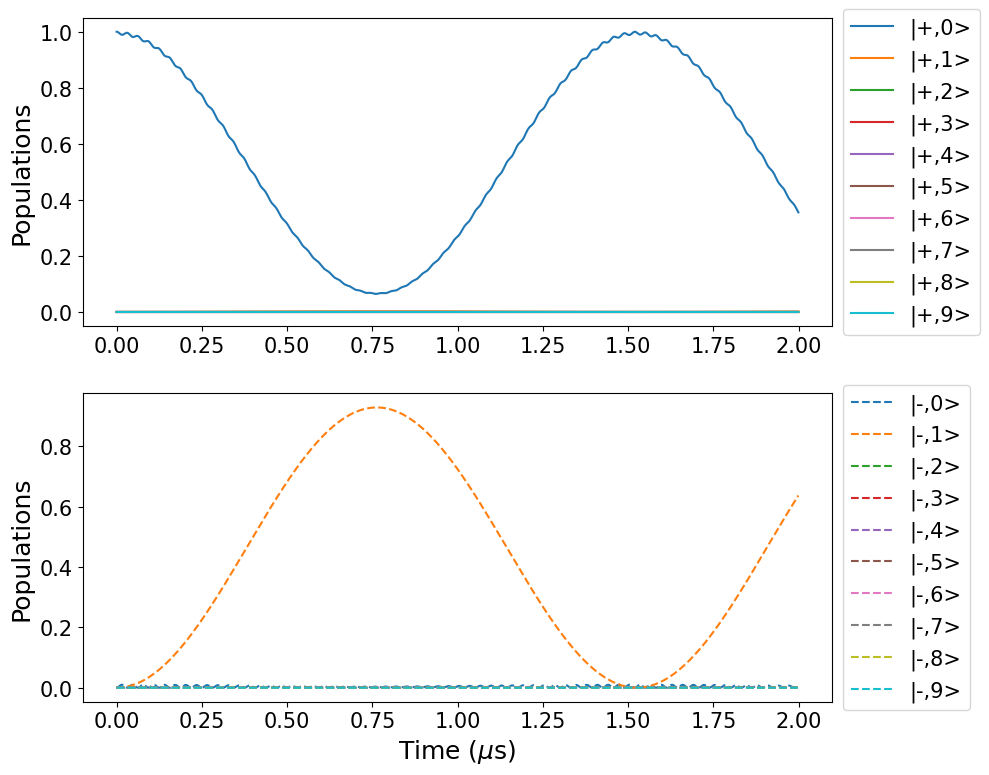

In [93]:
data = qload(states_filename)
plot_populations_single_mode_plus_minus_basis(data, figname = 'test', title = None, times_on_plot = None)
plt.show()

In [710]:
1/(chi1 * alpha * alpha)

200.0

In [690]:
1/0.03

33.333333333333336

In [691]:
chi1 * alpha1* alpha1

0.02

dominant term is the ac stark shift of the qubit which stops the swaps from happening. Why?

## Full enhanced dispersive interaction with Parametric Modulation
$$ H =  \Delta_{c} a ^\dagger a  + [\Omega_q + \epsilon \sin(\Delta_c t)] \sigma_x/2 - \chi \alpha(a^\dagger + a)\sigma_z  - \chi|\alpha|^2 \sigma_z - \chi a^\dagger a \sigma_z$$


In [85]:
alpha = 10
epsilon = 0.1
del_c1 = 0.02
dc_offset = 0.1

H0 = (del_c1*tensor(identity_q, num_c) +
     # +1* dc_offset * tensor(sigmax(), identity_c)/2  + 
     -1*chi1 * alpha * tensor(sigmaz(), a_c + adag_c) + 
    1* -1 * chi1 *  alpha * alpha * tensor(sigmaz(), identity_c)  +
     -1 * chi1 * tensor(sigmaz(), num_c)
     )
     

c_ops = []

times = np.linspace(0, 4000, 2000)
H = [H0, 
     [ epsilon*tensor(sigmax(), identity_c) /2,  np.array([np.sin(del_c1*t) for t in times], dtype = np.single)]
    ]

In [86]:
psi0 = tensor(plus, basis(n_c,0))
opts = Options(store_states=True, store_final_state=True, nsteps = 10000)
output = mesolve(H, psi0 , times, c_ops, [], options =opts)
states_filename = 'State_store_g0_g1_disp'
qsave(output.states, states_filename)
rho = output.states[-1]

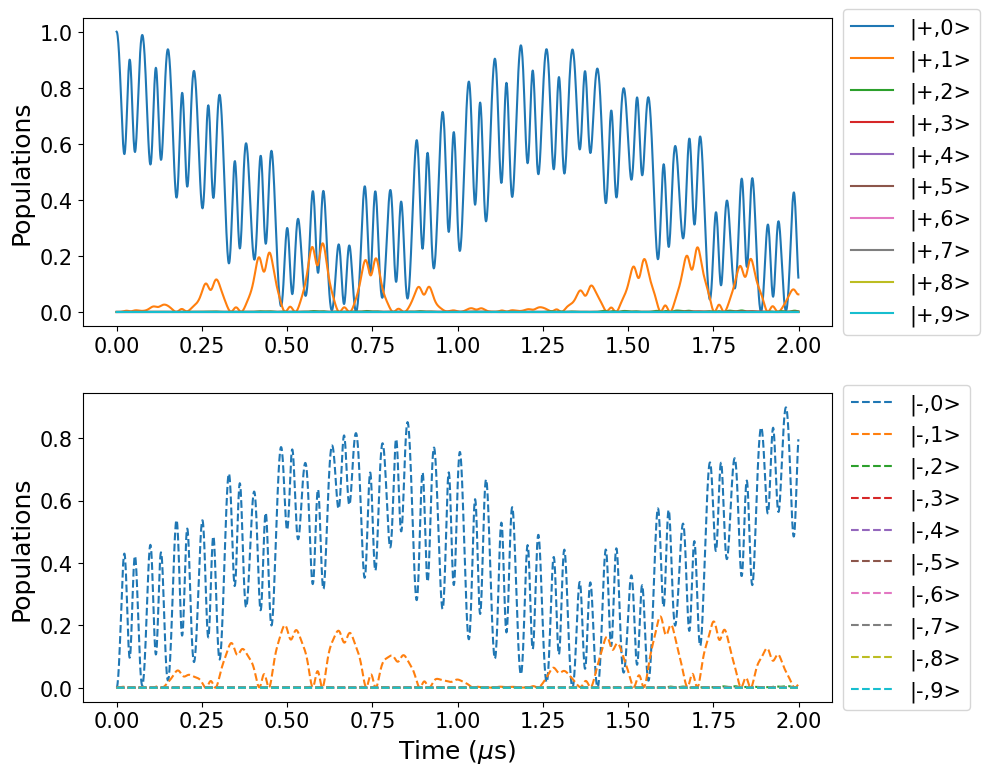

In [87]:
data = qload(states_filename)
plot_populations_single_mode_plus_minus_basis(data, figname = 'test', title = None, times_on_plot = None)
plt.show()

**Lesson**: Need qubit drive to be detuned by $\chi |\alpha|^2$ 

## Rotating Frame of the Drives
$$ H =  \Delta_c a^\dagger a  + \Delta_q \sigma_z  + \chi a^\dagger a \sigma_z + (\epsilon(t) a^\dagger + h.c.) + \Omega_q /2 \sigma_x$$



Assume perfect initial and final displacements (resonant cavity drive, rotating  in detuned frame)

The cavity drive in the waiting period is detuned (resonant in detuned frame)

### Testing Cavity Drive

In [86]:
cg = circ_grape()
cg.param['del_c1'] = 2 * np.pi * 0.07
cg.param['Omega_q'] = 2 * np.pi * (0.07 -0.054)
cg.param['epsilon'] = 2 * np.pi * 0.1

Gain to alpha:  0.0001105407
Gain to frequency (in kHz): 0.22329 


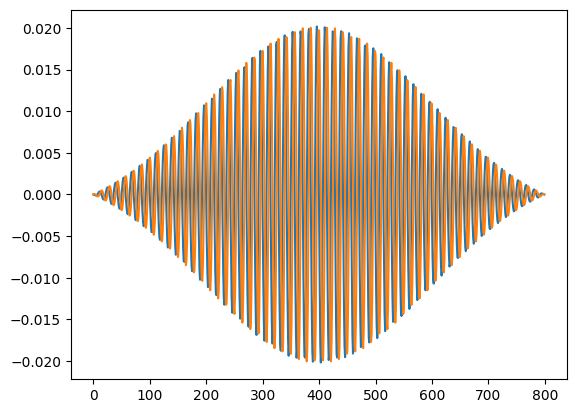

In [87]:
pulse = cg.cavity_drive(delta = cg.param['del_c1'], gain_to_alpha= 0.0001105407)
plt.plot(pulse.real)
plt.plot(pulse.imag)
plt.show()

In [88]:
10/0.0001105407

90464.4171784691

In [91]:
20000/0.22329

89569.6179855793

In [82]:
cg.param['alpha1']

10

In [71]:
cg.param['chi1'] * cg.param['alpha1']

0.012566370614359171

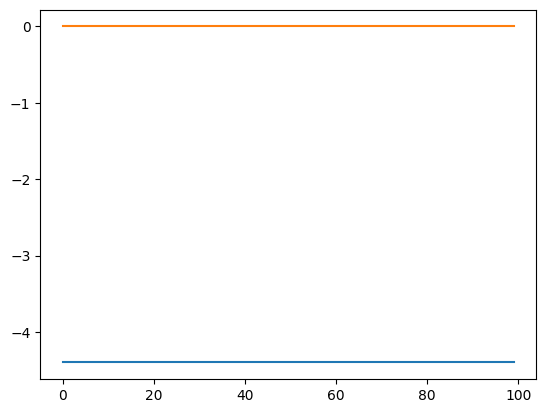

In [72]:
pulse = cg.cavity_drive_perf_disp(delta = cg.param['del_c1'])
plt.plot(pulse.real)
plt.plot(pulse.imag)
plt.show()

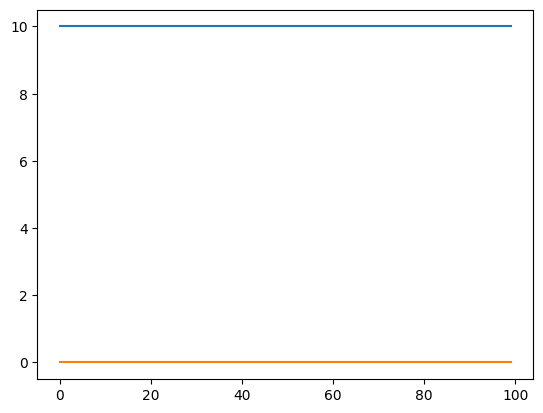

In [73]:
alpha = cg.alpha_from_epsilon_nonlinear_finite_difference(pulse, alpha_init=cg.param['alpha1'] + 0.0j, #cg.param['del_c1'],
                                                          delta = cg.param['del_c1'])#cg.param['del_c1'])
plt.plot(alpha.real)
plt.plot(alpha.imag)
plt.show()

Gain to alpha:  0.0001105407
Gain to frequency (in MHz): 0.00449 


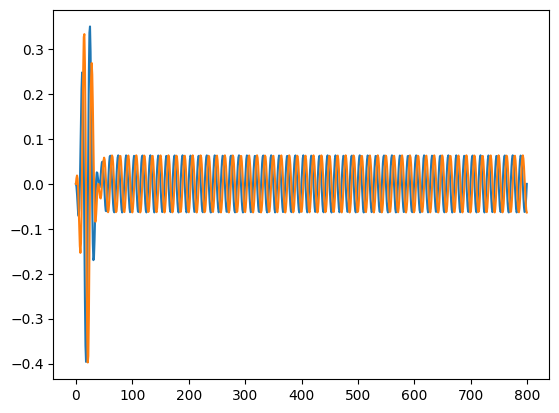

In [49]:
2 / 0.0001105407

18092.88343569382

### Resonant Case

In [424]:
cg = circ_grape(n_c = 70)
cg.param['del_c1'] = 2 * np.pi * 0.07
cg.param['Omega_q'] = cg.param['del_c1'] #2 * np.pi * (0.07 -0.054)
cg.param['epsilon'] = 0#2 * np.pi * 0.1
cg.param['alpha1'] = 5
#cg.param['del_q'] = cg.param['chi1'] * np.square(np.abs(cg.param['alpha1']))

In [425]:
cg.param['chi1'] #* np.square(np.abs(cg.param['alpha1']))

0.0012566370614359172

In [426]:
H0 = (cg.param['del_c1'] *tensor(cg.identity_q, cg.num_c) +
      #cg.param['del_q'] * tensor(sigmaz(), cg.identity_c)/2  + 
      cg.param['Omega_q'] * tensor(sigmax(), cg.identity_c)/2 +  # the dc part of drive
     -1 * cg.param['chi1'] *  tensor(sigmaz(), cg.num_c)
     )

In [427]:
cg.times = np.linspace(0, 2000, 2000)
Delta = np.abs(cg.param['del_c1'] - cg.param['Omega_q'])
sine = np.array([np.sin(Delta*t) for t in cg.times], dtype = np.single)

#time dependent drive
pulse = cg.cavity_drive_perf_disp(delta = cg.param['del_c1'], tw = len(cg.times))
#time dependent ac stark shift of qubit
alpha = cg.alpha_from_epsilon_nonlinear_finite_difference(epsilon_array=pulse, delta = cg.param['del_c1'],
                                                          alpha_init = cg.param['alpha1'])
cg.param['del_q'] = cg.param['chi1'] * alpha * np.conjugate(alpha)

cg.H = [H0, 
    [ +1*cg.param['epsilon']*tensor(sigmax(), cg.identity_c)/2 , sine], # rf drive 
    [tensor(cg.identity_q, cg.adag_c), pulse], 
    [tensor(cg.identity_q, cg.a_c), np.conjugate(pulse)],
    [tensor(sigmaz(), cg.identity_c ), cg.param['del_q']]
    ]

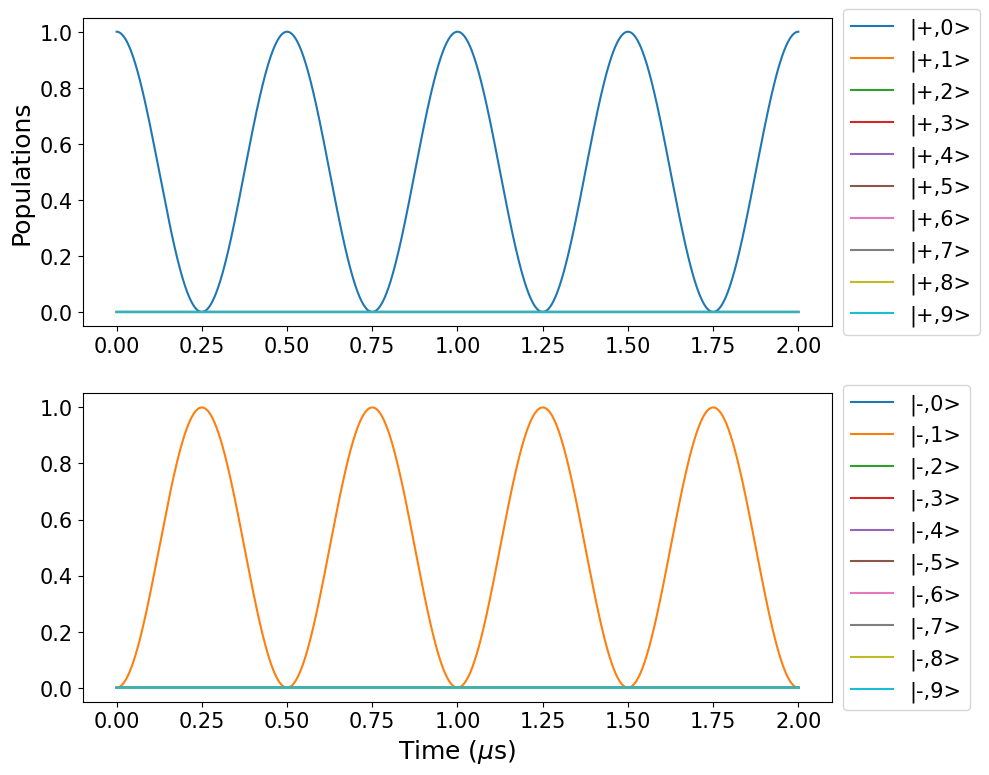

In [428]:
cg.solve_master(init = tensor(cg.identity_q, displace(cg.n_c, cg.param['alpha1'])) * tensor(cg.plus, basis(cg.n_c,0))
)
states = cg.plot_populations_single_mode_plus_minus_basis(displace_back = True)

### Parametric Case

In [380]:
cg = circ_grape(n_c = 70)
cg.param['del_c1'] = 2 * np.pi * 0.07
cg.param['Omega_q'] = 2 * np.pi * (0.07 -0.054)
cg.param['epsilon'] = 2 * np.pi * 0.1
cg.param['alpha1'] = 5
#cg.param['del_q'] = cg.param['chi1'] * np.square(np.abs(cg.param['alpha1']))

In [381]:
cg.param['chi1'] #* np.square(np.abs(cg.param['alpha1']))

0.0012566370614359172

In [382]:
H0 = (cg.param['del_c1'] *tensor(cg.identity_q, cg.num_c) +
      #cg.param['del_q'] * tensor(sigmaz(), cg.identity_c)/2  + 
      cg.param['Omega_q'] * tensor(sigmax(), cg.identity_c)/2 +  # the dc part of drive
     -1 * cg.param['chi1'] *  tensor(sigmaz(), cg.num_c)
     )

In [383]:
cg.times = np.linspace(0, 2000, 2000)
Delta = np.abs(cg.param['del_c1'] - cg.param['Omega_q'])
sine = np.array([np.sin(Delta*t) for t in cg.times], dtype = np.single)

#time dependent drive
pulse = cg.cavity_drive_perf_disp(delta = cg.param['del_c1'], tw = len(cg.times))
#time dependent ac stark shift of qubit
alpha = cg.alpha_from_epsilon_nonlinear_finite_difference(epsilon_array=pulse, delta = cg.param['del_c1'],
                                                          alpha_init = cg.param['alpha1'])
cg.param['del_q'] = cg.param['chi1'] * alpha * np.conjugate(alpha)

cg.H = [H0, 
    [ +1*cg.param['epsilon']*tensor(sigmax(), cg.identity_c)/2 , sine], # rf drive 
    [tensor(cg.identity_q, cg.adag_c), pulse], 
    [tensor(cg.identity_q, cg.a_c), np.conjugate(pulse)],
    [tensor(sigmaz(), cg.identity_c ), cg.param['del_q']]
    ]

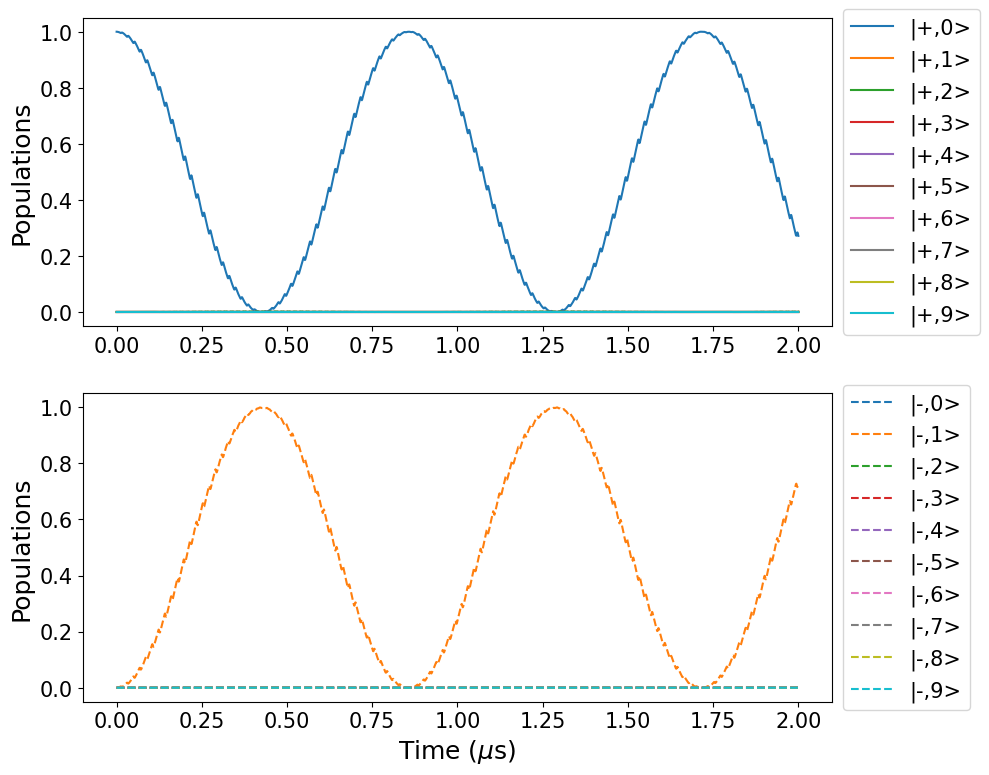

In [386]:
cg.solve_master(init = tensor(cg.identity_q, displace(cg.n_c, cg.param['alpha1'])) * tensor(cg.plus, basis(cg.n_c,0))
)
states = cg.plot_populations_single_mode_plus_minus_basis(displace_back = True)

## Rotating Frame of the Drives with Duffing Oscillator
$$ H =  \Delta_c a^\dagger a  + \Delta_q q^\dagger q - Kq^\dagger q^\dagger q q - \chi a^\dagger a q^\dagger q + (\epsilon(t) a^\dagger + h.c.) + ([\Omega_q + \epsilon \sin(\Delta t) ]q^\dagger + h.c.)/2$$



Assume perfect initial and final displacements (resonant cavity drive, rotating  in detuned frame)

The cavity drive in the waiting period is detuned (resonant in detuned frame)

### Resonant Circle Grape

In [60]:
cg = circ_grape(n_q = 5, n_c = 70)
cg.param['del_c1'] = 2 * np.pi * 0.07
cg.param['Omega_q'] = cg.param['del_c1']#2 * np.pi * (0.07 -0.054)
cg.param['epsilon'] = 0#2 * np.pi * 0.1
cg.param['Kq'] = 2 * np.pi * 0.15
cg.param['alpha1'] = 5

In [61]:
cg.param['chi1'] #* np.square(np.abs(cg.param['alpha1']))

0.0012566370614359172

In [62]:
H0 = (cg.param['del_c1'] *tensor(cg.identity_q, cg.num_c) +
      #cg.param['del_q'] * tensor(sigmaz(), cg.identity_c)/2  + 
      cg.param['Omega_q'] * tensor(cg.adag_q , cg.identity_c)/2 +  # the dc part of drive
      np.conjugate(cg.param['Omega_q']) * tensor(cg.a_q , cg.identity_c)/2 +  # the dc part of drive
     -1 * cg.param['chi1'] *  tensor(cg.num_q, cg.num_c) + 
     -1 * cg.param['Kq'] * tensor(cg.quart_nonlin_q, cg.identity_c)
     )

In [63]:
cg.times = np.linspace(0, 2000, 2000)
Delta = np.abs(cg.param['del_c1'] - cg.param['Omega_q'])
sine = np.array([np.sin(Delta*t) for t in cg.times], dtype = np.single)

#time dependent drive
pulse = cg.cavity_drive_perf_disp(delta = cg.param['del_c1'], tw = len(cg.times))
#time dependent ac stark shift of qubit
alpha = cg.alpha_from_epsilon_nonlinear_finite_difference(epsilon_array=pulse, delta = cg.param['del_c1'],
                                                          alpha_init = cg.param['alpha1'])
cg.param['del_q'] = cg.param['chi1'] * alpha * np.conjugate(alpha)

cg.H = [H0, 
    [tensor(cg.adag_q, cg.identity_c)/2 , cg.param['epsilon'] * sine], # rf drive 
    [tensor(cg.a_q, cg.identity_c)/2 , np.conjugate(cg.param['epsilon'] *sine)],
    [tensor(cg.identity_q, cg.adag_c), pulse], 
    [tensor(cg.identity_q, cg.a_c), np.conjugate(pulse)],
    [tensor(cg.num_q, cg.identity_c ), cg.param['del_q']]
    ]

In [64]:
cg.solve_master(init = tensor(cg.identity_q, displace(cg.n_c, cg.param['alpha1'])) * tensor(cg.plus, basis(cg.n_c,1))
)

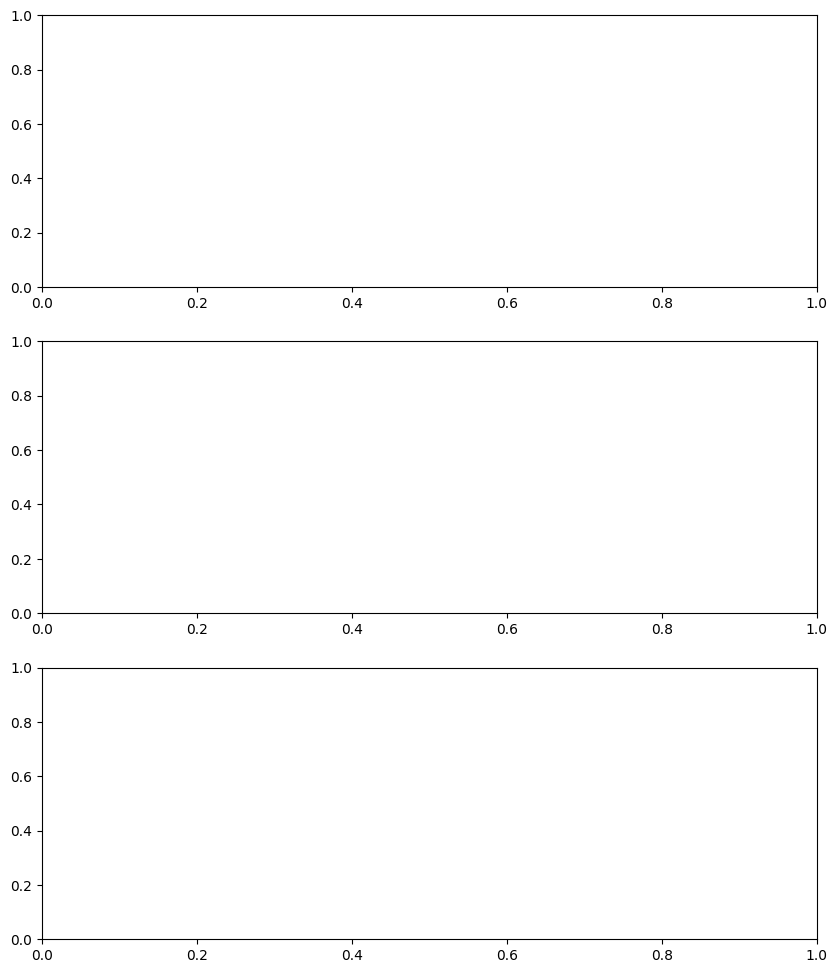

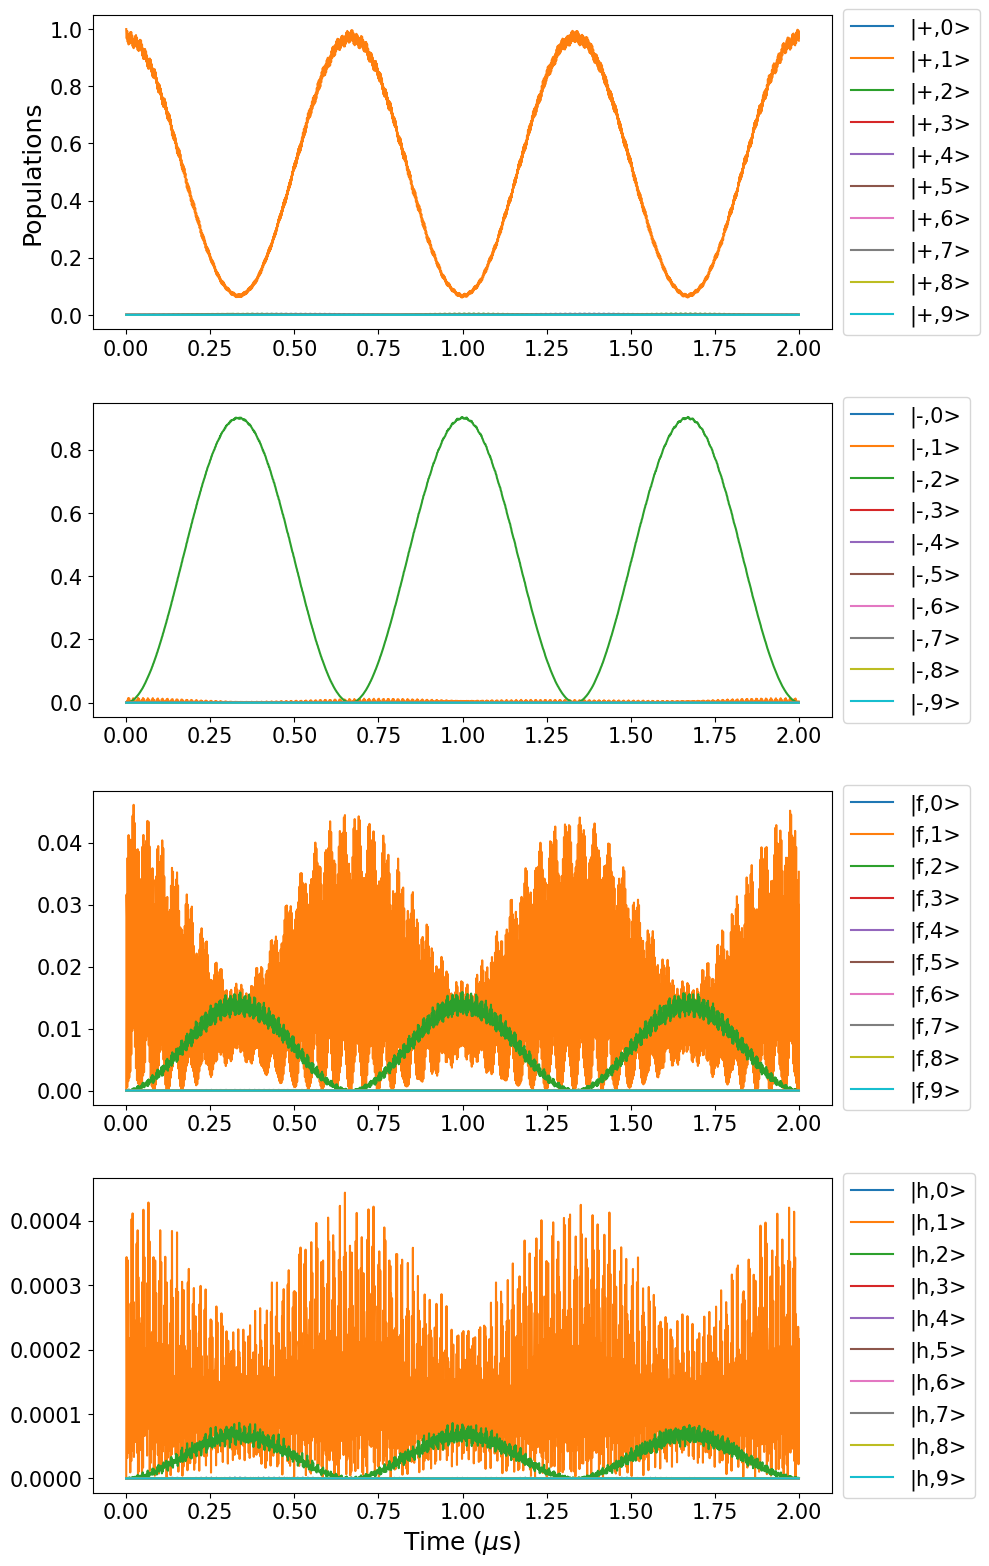

In [66]:
cg.plot_populations_single_mode_plus_minus_basis(displace_back = True, f_state=True, h_state = True)

Seems like we are off-resonantly driving the f state. The error increases with decreasing anharmonicity 

### Parametric Circle Grape

In [81]:
cg = circ_grape(n_q = 5, n_c = 70)
cg.param['del_c1'] = 2 * np.pi * 0.07
cg.param['Omega_q'] = 2 * np.pi * (0.07 -0.054)
cg.param['epsilon'] = 2 * np.pi * 0.1
cg.param['Kq'] = 2 * np.pi * 0.15
cg.param['alpha1'] = 5

In [82]:
cg.param['chi1'] #* np.square(np.abs(cg.param['alpha1']))

0.0012566370614359172

In [83]:
H0 = (cg.param['del_c1'] *tensor(cg.identity_q, cg.num_c) +
      #cg.param['del_q'] * tensor(sigmaz(), cg.identity_c)/2  + 
      cg.param['Omega_q'] * tensor(cg.adag_q , cg.identity_c)/2 +  # the dc part of drive
      np.conjugate(cg.param['Omega_q']) * tensor(cg.a_q , cg.identity_c)/2 +  # the dc part of drive
     -1 * cg.param['chi1'] *  tensor(cg.num_q, cg.num_c) + 
     -1 * cg.param['Kq'] * tensor(cg.quart_nonlin_q, cg.identity_c)
     )

In [84]:
cg.times = np.linspace(0, 2000, 2000)
Delta = np.abs(cg.param['del_c1'] - cg.param['Omega_q'])
sine = np.array([np.sin(Delta*t) for t in cg.times], dtype = np.single)

#time dependent drive
pulse = cg.cavity_drive_perf_disp(delta = cg.param['del_c1'], tw = len(cg.times))
#time dependent ac stark shift of qubit
alpha = cg.alpha_from_epsilon_nonlinear_finite_difference(epsilon_array=pulse, delta = cg.param['del_c1'],
                                                          alpha_init = cg.param['alpha1'])
cg.param['del_q'] = cg.param['chi1'] * alpha * np.conjugate(alpha)

cg.H = [H0, 
    [tensor(cg.adag_q, cg.identity_c)/2 , cg.param['epsilon'] * sine], # rf drive 
    [tensor(cg.a_q, cg.identity_c)/2 , np.conjugate(cg.param['epsilon'] *sine)],
    [tensor(cg.identity_q, cg.adag_c), pulse], 
    [tensor(cg.identity_q, cg.a_c), np.conjugate(pulse)],
    [tensor(cg.num_q, cg.identity_c ), cg.param['del_q']]
    ]

In [85]:
cg.solve_master(init = tensor(cg.identity_q, displace(cg.n_c, cg.param['alpha1'])) * tensor(cg.plus, basis(cg.n_c,1))
)

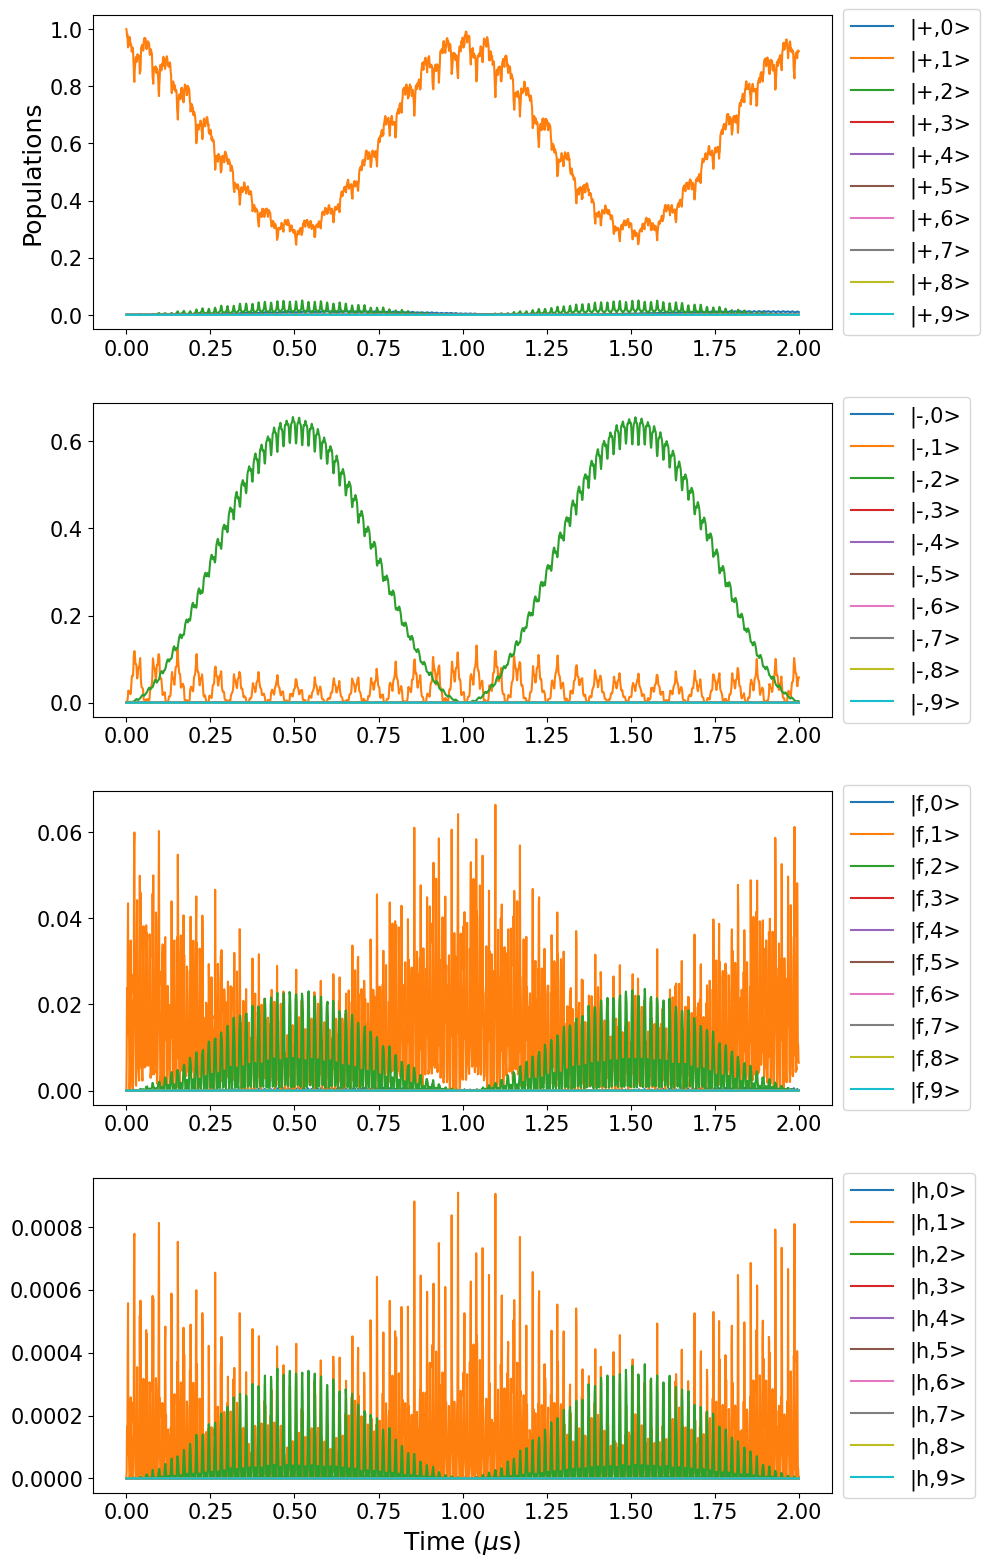

In [86]:
cg.plot_populations_single_mode_plus_minus_basis(displace_back = True, f_state=True, h_state = True)

# Two Modes coupled to a qubit

## Class

In [32]:
class circ_grape_two_mode: 
    def __init__(self, n_q=2, n_c=30, param = {'chi1' : 2 * np.pi * 200 * 1e-6, # in units of Ghz
                                     'chi2' : 2 * np.pi * 240 * 1e-6,
                                     'alpha1' : 10 ,
                                     'alpha2' : 10,
                                     'del_c1' : 2 * np.pi * 10 * 1e-3,  # Cavity drive detunings 
                                     'del_c2' : 2 * np.pi * 10 * 1e-3,
                                     'Omega_q' :2 * np.pi * 10 * 1e-3,
                                     'epsilon': 2 * np.pi * 100 * 1e-3,
                                     'Kq': 2 * np.pi * 0.1}): 
        self.n_q = n_q
        self.n_c = n_c
        self.init_operators_and_states()
        self.param = param
        self.H = None
        self.times = None


    def init_operators_and_states(self):
        #qutip ops
        # Creating identity, annhilitation/creation, num operators 
        self.identity_q = qeye(self.n_q)
        self.identity_c = qeye(self.n_c)

        self.a_q = destroy(self.n_q)
        self.a_c = destroy(self.n_c)

        self.adag_q = create(self.n_q)
        self.adag_c = create(self.n_c)

        self.num_q = num(self.n_q)
        self.num_c =  num(self.n_c)

        #nonlinearity
        self.quart_nonlin_q = self.adag_q  * self.adag_q  * self.a_q * self.a_q

        self.g_state = basis(self.n_q, 0 )
        self.e_state = basis(self.n_q, 1 )
        self.plus = (basis(self.n_q, 0 ) + basis(self.n_q, 1)) / np.sqrt(2)
        self.minus = (basis(self.n_q, 0 ) - basis(self.n_q, 1)) / np.sqrt(2)

    """Cavity Drive Functions"""
    def gaussian(self, t, amp = 1):
        '''
        returns a point sampled from a gaussian centered at t = 20
        '''
        sigma = 10
        chop = 4
        ts = np.linspace(-chop / 2 * sigma, chop / 2 * sigma, chop * sigma)
        Ps = amp * np.exp(-((ts)**2) / (2.0 * sigma**2))
        ofs = Ps[0]
        
        p = amp * np.exp(-((t-20)**2) / (2.0 * sigma**2))
        
        p = (p - ofs) / (1 - ofs)
        #print(ofs)
        return p 

    def norm_gaussian_wave(self, t, omega_d):
        '''
        returns a point sampled from a gaussian centered at t = 20
        with sinusodial component modulating at omega d
        '''
        area = scipy.integrate.quad(self.gaussian, 0, 40 )[0]
        p = self.gaussian(t, amp = 1/area)
        
        return p * np.exp(1.0j * omega_d * t) # add 2 pi later

    def alpha_from_epsilon_nonlinear_finite_difference(self, epsilon_array, delta=0, alpha_init=0 + 0.0j):
        '''
        Copied from Alec Eickbush ECD

        viewing delta is the "detuning" from the original frame. This new frame is from where 
        we view the dynamics
        '''
        dt = 1
        alpha = np.zeros_like(epsilon_array)
        alpha[0] = alpha_init
        alpha[1] = alpha_init
        for j in range(1, len(epsilon_array) - 1):
            alpha[j + 1] = (
                    2*dt * (
                        -1j * delta * alpha[j] + 
                        - 1j * epsilon_array[j] #* np.exp(-1j* viewing_delta * j*dt)
                        #- 2j * Ks * np.abs(alpha[j]) ** 2 * alpha[j]
                        #- (kappa / 2.0) * alpha[j]
                    )
                    + alpha[j - 1]
                    )
        return alpha
    
    def cavity_drive_perf_disp(self, omega_d = 0, tw = 100, delta = 0, alpha = None):
        '''
        Assume initial cavity displacements are perfect

        Note that this pulse is as viewed in the detuned frame. (this pulse in lab frame is off resonant)
        '''
        if alpha == None: 
            alpha = self.param['alpha1']
        wait = np.array([-1 * delta * alpha + 0.0j for _ in range(tw)])
        return wait

    
    def cavity_drive(self, omega_d = 0 , tw = 100, delta = 0):
        '''
        tw is wait time 
        pulse pattern - displace - wait - displace back

        Progress: the initial displacement should be a resonant pulse which should be viewed in the 
        detuned frame with e ^ i Delta t. However, b.c of equation of motion, it does not reach the target alpha. 
        We need to do some kind of optimization (increase amplitude) until |alpha| reaches th target alpha
        '''
        alpha = self.param['alpha1']
        ts = np.linspace(0, 40, 40)
        # delta factor matters as solution is eps/delta
        wave =  1.0j * alpha * self.norm_gaussian_wave(ts, omega_d)
        #if this resonant is viewed in the detuned frame
        wave_exps = np.array([wave[idx] * np.exp(1.0j* delta*ts[idx]) for idx in range(len(wave))])
        alpha0= self.alpha_from_epsilon_nonlinear_finite_difference(wave_exps, delta = delta)[-1] #* np.exp(1.0j * delta * 1)

        # pulse pattern - displace - wait - displace back
        disp =  wave_exps.copy()
        wait = np.array([-1 * delta * alpha0 for _ in range(tw)])
        #disp_back =  wave.copy() * -1 * np.exp(-1.0j * delta * ( len(disp)))
        #on back pulse, the exponential factor (since wave is resonant viewed in detuned frame) needs to take account of time of whole pulse
        disp_back = -1* np.array([wave[idx] * np.exp(1.0j* delta*( ts[idx])) for idx in range(len(wave))]) * np.exp(-1.0j * delta * ( len(disp)))
        pulse = np.concatenate((disp, wait, disp_back))
        return pulse 

        
    
    def solve_master(self, times = None, init = None): 
        '''
        solve master equation
        '''
        if self.times is None: 
            self.times = times
        opts = Options(store_states=True, store_final_state=True, nsteps = 10000)
        self.output = mesolve(self.H, init , self.times, [], [], options =opts) 

    def get_fidelity(self, state, target) : 
        def dot( state1, state2):
                '''
                dotting both states
                '''
                fid = state1.overlap(state2)
                return fid*np.conjugate(fid)
            
        if (state.type == 'ket') and (target.type == 'ket'):
            result = dot(state, target)

        elif (state.type == 'oper') and (target.type == 'ket'): #density matrix alert
            target_rho= target*target.dag()
            result = np.sqrt(dot(state, target_rho)) # Hilbert schmidt prod is enough, no need for squaring (try to do this for pure states and you'll get why sqrt used here)
        return result


    
    def plot_populations_two_mode(self, figname= None, title= None, displace_back = False, plus_minus = False,
                                                      f_state = False, h_state = False):
        '''
        plus_minus: whether to show qubit state in sigma-x basis
        
        Given output of mesolve, outputs populations with qubit as plus
        '''
        output_states = self.output.states
        probs = []
        times = self.times
        max_num_levels = 3 # to be shown on the plot
        if displace_back:
            op = tensor(self.identity_q, displace(self.n_c, -1* self.param['alpha1']), displace(self.n_c, -1* self.param['alpha2']))
            output_states = [op* state for state in output_states]
        
       # return output_states
        
        q_state_label = ['+', '-', 'f', 'h'] if plus_minus else ['g', 'e', 'f', 'h']
        q_states = [self.plus, self.minus] if plus_minus else [self.g_state, self.e_state]
        if f_state: 
            q_states.append(basis(self.n_q, 2 ))
        if h_state: 
            q_states.append(basis(self.n_q, 3))
        
        fig, axs = plt.subplots(len(q_states),1, figsize=(10, 4 * len(q_states)))
        
        for idx, q_state in enumerate(q_states): 
            for i in range(max_num_levels):
                for j in range(max_num_levels):
                    target = tensor(q_state, basis(self.n_c, i), basis(self.n_c, j))
                    pops = []
                    for k in range(len(output_states)): 
                        z = target.overlap(output_states[k])
                        pops.append(z.real**2 + z.imag**2)
                    axs[idx].plot(times*1e-3, pops, label = '|' + q_state_label[idx]+ ','+str(i)+','+ str(j) + '>')
                
            #formatting 
            axs[idx].tick_params(axis = 'both', which = 'major', labelsize = '15')
            axs[idx].tick_params(axis = 'both', which = 'minor', labelsize = '15')
            axs[idx].legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize = '15')
        axs[-1].set_xlabel(r"Time ($\mu$s)", fontsize = 18)
        axs[0].set_ylabel("Populations", fontsize = 18)
        plt.tight_layout()
        #fig.savefig(figname, dpi = 1000)

## Displaced Frame  + Hadamard Hamiltonian

$$ H = \sum_{i = 1,2} \Delta_{c, i} a_i ^\dagger a  - \Omega_q \sigma_z/2 + \chi_i \alpha_i (a_i^\dagger + a)(\sigma^+ + \sigma^-) $$

In [32]:
cg = circ_grape_two_mode()
cg.param['del_c1'] = 2 * np.pi * 0.02
cg.param['del_c2'] = cg.param['del_c1']
cg.param['Omega_q'] = 2 * np.pi * 0.02
cg.param['alpha1'] = 5
cg.param['alpha2'] = cg.param['alpha1']

In [33]:
H0 = (cg.param['del_c1'] *tensor(cg.identity_q, cg.num_c, cg.identity_c) +
      cg.param['del_c2'] *tensor(cg.identity_q, cg.identity_c, cg.num_c) +
      -1* cg.param['Omega_q'] * tensor(sigmaz(), cg.identity_c, cg.identity_c)/2  + 
     cg.param['chi1'] * cg.param['alpha1'] * tensor(sigmax(), cg.a_c + cg.adag_c, cg.identity_c) + 
     cg.param['chi2'] * cg.param['alpha2'] * tensor(sigmax(), cg.identity_c , cg.a_c + cg.adag_c)
     )
cg.H = [H0]

In [34]:
cg.solve_master(times = np.linspace(0, 2000, 500), 
                init = tensor(basis(cg.n_q,0), basis(cg.n_c,1), basis(cg.n_c, 0))
)

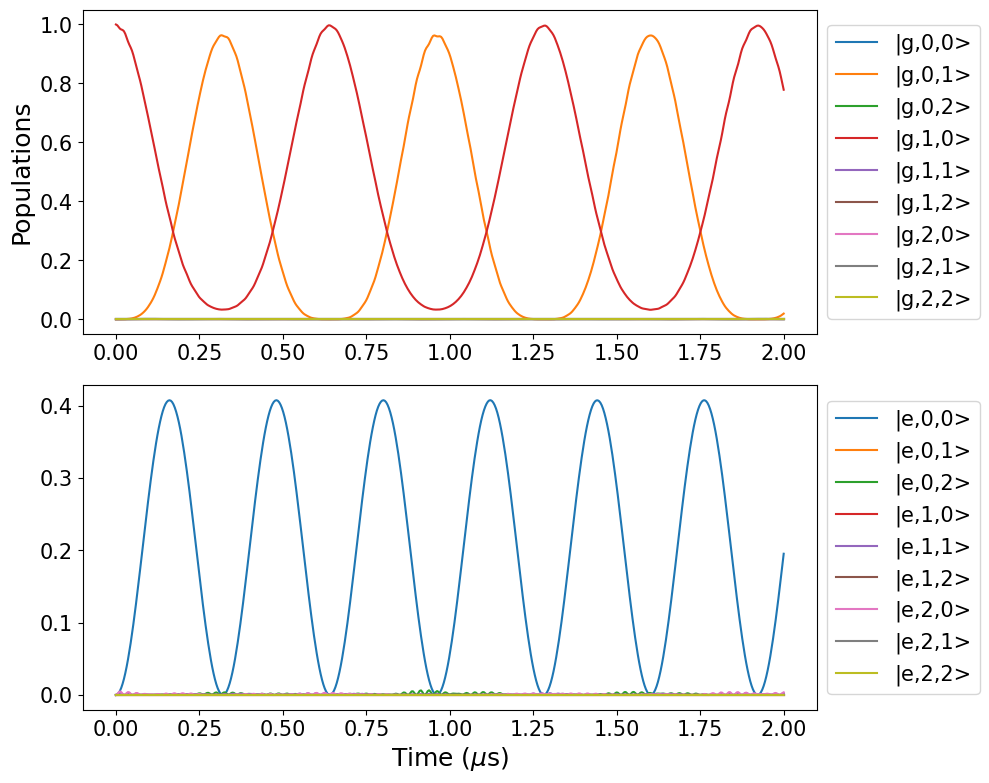

In [35]:
cg.plot_populations_two_mode()

## Displaced Frame + other terms from enhanced dispersive interaction
$$ H = \sum_{i = 1,2} \Delta_{c, i} a_i ^\dagger a  + \Omega_q \sigma_x/2 - \chi_i \alpha_i (a_i^\dagger + a)\sigma_z -\chi_i a^\dagger a \sigma_z - \chi_i |\alpha_i|^2 \sigma_z$$

In [23]:
cg = circ_grape_two_mode(n_c = 30)
cg.param['del_c1'] = 2 * np.pi * 0.02
cg.param['del_c2'] = cg.param['del_c1']
cg.param['Omega_q'] = 2 * np.pi * 0.02
cg.param['alpha1'] = 5
cg.param['alpha2'] = cg.param['alpha1']

In [24]:
H0 = (cg.param['del_c1'] *tensor(cg.identity_q, cg.num_c, cg.identity_c) + # detuning 
      cg.param['del_c2'] *tensor(cg.identity_q, cg.identity_c, cg.num_c) +

       cg.param['Omega_q'] * tensor(sigmax(), cg.identity_c, cg.identity_c)/2  + # qubit drive

     -1 * cg.param['chi1'] *  tensor(sigmaz(), 
                                (cg.a_c + cg.param['alpha1'] * cg.identity_c) * 
                                (cg.adag_c  + np.conjugate(cg.param['alpha1']) * cg.identity_c), 
                                cg.identity_c) + #conditional disp
     -1 * cg.param['chi2'] *  tensor(sigmaz(), cg.identity_c , 
                                (cg.a_c + cg.param['alpha2'] * cg.identity_c) * 
                                (cg.adag_c  + np.conjugate(cg.param['alpha2']) * cg.identity_c)) 
     )
cg.H = [H0]

In [25]:
cg.solve_master(times = np.linspace(0, 2000, 500), 
                init = tensor(basis(cg.n_q,0), basis(cg.n_c,1), basis(cg.n_c, 0))
)

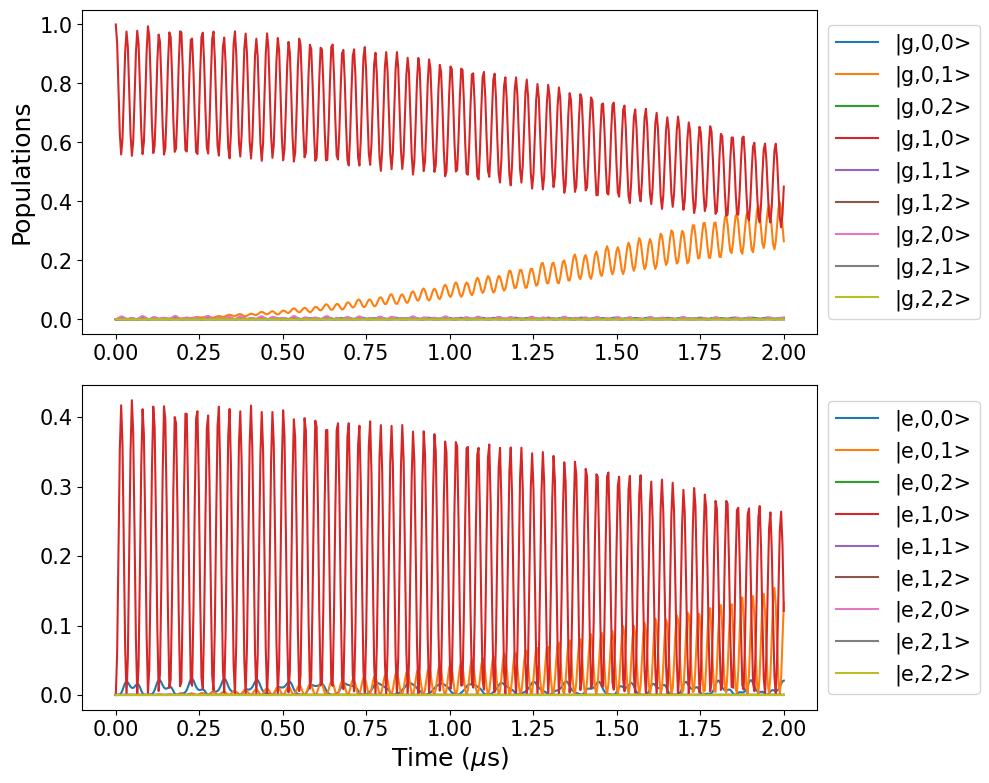

In [26]:
cg.plot_populations_two_mode()

#### Removing the Stark Shift with $\Delta_q \sigma_z$

In [49]:
cg = circ_grape_two_mode()
cg.param['del_c1'] = 2 * np.pi * 0.05
cg.param['del_c2'] = cg.param['del_c1']
cg.param['Omega_q'] = 2 * np.pi * 0.05
cg.param['alpha1'] = 5
cg.param['alpha2'] = cg.param['alpha1']
cg.param['del_q'] = (cg.param['chi1'] * np.square(np.abs(cg.param['alpha1'])) + 
                     cg.param['chi2'] * np.square(np.abs(cg.param['alpha2'])))


In [50]:
H0 = (cg.param['del_c1'] * tensor(cg.identity_q, cg.num_c, cg.identity_c) + # detuning 
      cg.param['del_c2'] * tensor(cg.identity_q, cg.identity_c, cg.num_c) +
      cg.param['del_q'] * tensor(sigmaz(), cg.identity_c, cg.identity_c) + 

       cg.param['Omega_q'] * tensor(sigmax(), cg.identity_c, cg.identity_c)/2  + # qubit drive

     -1 * cg.param['chi1'] *  tensor(sigmaz(), 
                                (cg.a_c + cg.param['alpha1'] * cg.identity_c) * 
                                (cg.adag_c  + np.conjugate(cg.param['alpha1']) * cg.identity_c), 
                                cg.identity_c) + #conditional disp
     -1 * cg.param['chi2'] *  tensor(sigmaz(), cg.identity_c , 
                                (cg.a_c + cg.param['alpha2'] * cg.identity_c) * 
                                (cg.adag_c  + np.conjugate(cg.param['alpha2']) * cg.identity_c)) 
     )
cg.H = [H0]

In [51]:
cg.solve_master(times = np.linspace(0, 2000, 500), 
                init = tensor(cg.minus, basis(cg.n_c,1), basis(cg.n_c, 0))
)

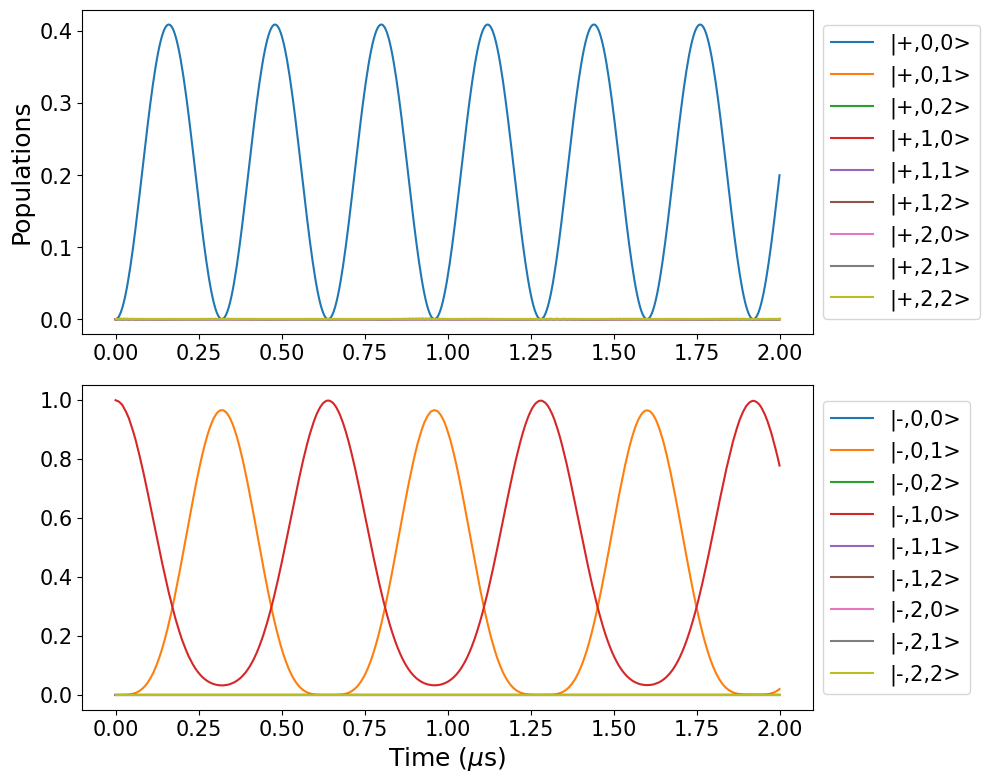

In [52]:
cg.plot_populations_two_mode(plus_minus = True)

## Rotating frame of the drives
$$ H = \sum_{i = 1,2} \Delta_{c, i} a_i ^\dagger a  + \Delta_q \sigma_z /2+  \Omega_q \sigma_x/2 - \chi_i a_i^\dagger a\sigma_z + [\epsilon(t) a^\dagger + h.c.] $$

In [38]:
cg = circ_grape_two_mode(n_c = 40)
cg.param['del_c1'] = 2 * np.pi * 0.05
cg.param['del_c2'] = cg.param['del_c1']
cg.param['Omega_q'] = 2 * np.pi * 0.05
cg.param['alpha1'] = 5
cg.param['alpha2'] = cg.param['alpha1']

In [39]:
H0 = (cg.param['del_c1'] * tensor(cg.identity_q, cg.num_c, cg.identity_c) + # detuning 
      cg.param['del_c2'] * tensor(cg.identity_q, cg.identity_c, cg.num_c) +

       cg.param['Omega_q'] * tensor(sigmax(), cg.identity_c, cg.identity_c)/2  + # qubit drive

     -1 * cg.param['chi1'] *  tensor(sigmaz(), cg.num_c, cg.identity_c) + # dispersive interaction
     -1 * cg.param['chi2'] *  tensor(sigmaz(), cg.identity_c , cg.num_c) 
     )
cg.H = [H0]

In [40]:
cg.times = np.linspace(0, 2000, 2000)
#time dependent drive
pulse1 = cg.cavity_drive_perf_disp(delta = cg.param['del_c1'], alpha = cg.param['alpha1'], tw = len(cg.times))
pulse2 = cg.cavity_drive_perf_disp(delta = cg.param['del_c2'], alpha = cg.param['alpha2'], tw = len(cg.times))
#time dependent ac stark shift of qubit
alpha1 = cg.alpha_from_epsilon_nonlinear_finite_difference(epsilon_array=pulse1, delta = cg.param['del_c1'],
                                                          alpha_init = cg.param['alpha1'])
alpha2 = cg.alpha_from_epsilon_nonlinear_finite_difference(epsilon_array=pulse2, delta = cg.param['del_c2'],
                                                          alpha_init = cg.param['alpha2'])
cg.param['del_q'] = (cg.param['chi1'] * alpha1 * np.conjugate(alpha1) + 
                     cg.param['chi2'] * alpha2 * np.conjugate(alpha2))

cg.H = [H0, 
    #[ +1*cg.param['epsilon']*tensor(sigmax(), cg.identity_c)/2 , sine], # rf drive 

    [tensor(cg.identity_q, cg.adag_c, cg.identity_c), pulse1], # drive mode 1
    [tensor(cg.identity_q, cg.a_c, cg.identity_c), np.conjugate(pulse1)],
    [tensor(cg.identity_q, cg.identity_c, cg.adag_c), pulse2], # drive mode 2
    [tensor(cg.identity_q, cg.identity_c, cg.a_c), np.conjugate(pulse2)],
    [tensor(sigmaz(), cg.identity_c, cg.identity_c), cg.param['del_q']] # qubit detuning 
    ]

In [41]:
psi0 = tensor(cg.minus, basis(cg.n_c,1), basis(cg.n_c, 0))
init_disp_op = tensor(cg.identity_q, displace(cg.n_c, cg.param['alpha1']), displace(cg.n_c, cg.param['alpha2']))
cg.solve_master(init = init_disp_op * psi0 )

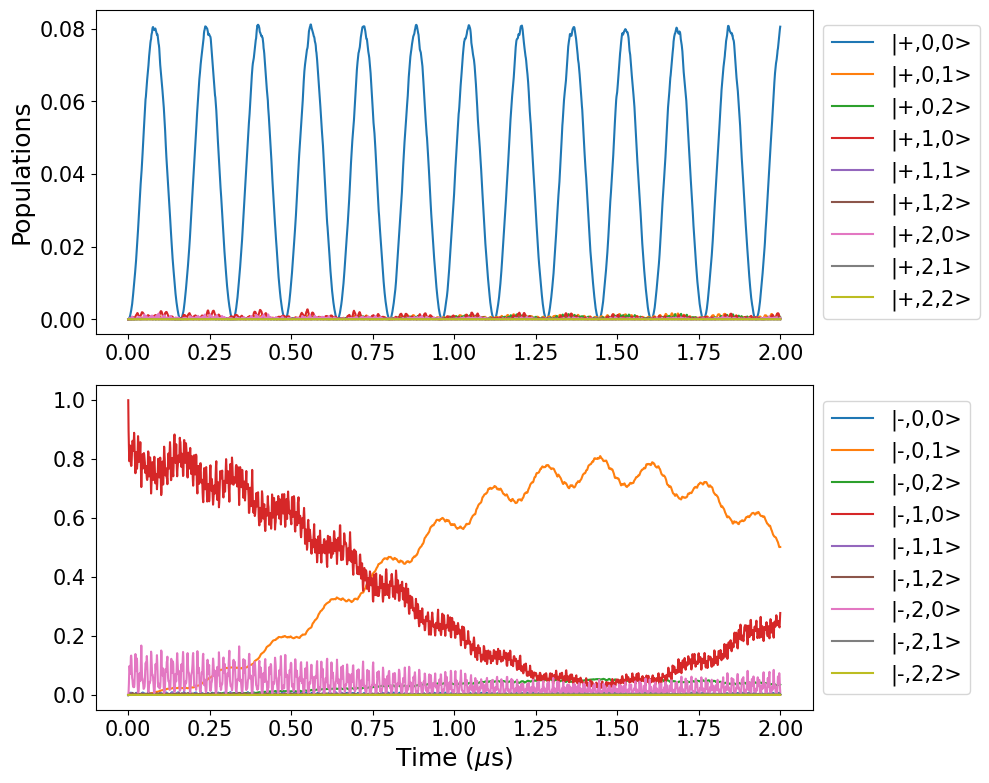

In [42]:
cg.plot_populations_two_mode(displace_back=True, plus_minus = True)

In [ ]:
H0 = (del_c1*tensor(identity_q, num_c, identity_c) +
      del_c2*tensor(identity_q, identity_c, num_c) +
      
      +1* Omega_q * tensor(sigmax(), identity_c, identity_c)/2   + 
      -1* chi1 * alpha1 * tensor(sigmaz(), a_c + adag_c, identity_c) +   # cpnd disp
      -1* chi2 * alpha2 * tensor(sigmaz(), identity_c, a_c + adag_c)
      
      -1* chi1 * alpha1 * tensor(sigmaz(), num_c, identity_c) # dispersive interaction
      -1* chi2 * alpha2 * tensor(sigmaz(), identity_c, num_c)
      
      -1* chi1 * alpha1 * alpha1 * tensor(sigmaz(), identity_c, identity_c) # AC stark shifts
      -1* chi2 * alpha2 * alpha2 * tensor(sigmaz(), identity_c, identity_c)
     )
     
cos1 = np.array([np.cos(del_c1 * t) for t in times])
cos2 = np.array([np.cos(del_c2 * t) for t in times])

H = [H0, 
    #[ 2*chi1 * alpha1 * tensor(sigmax(), a_c + adag_c, identity_c), cos1], 
     # [2*chi2 * alpha2 * tensor(sigmax(), identity_c, a_c + adag_c), cos2]
    ]
c_ops = []

In [ ]:
plus = (basis(n_q, 0 ) + basis(n_q, 1)) / np.sqrt(2)
plus = (basis(n_q, 0 ) + basis(n_q, 1)) / np.sqrt(2)
minus = (basis(n_q, 0 ) - basis(n_q, 1)) / np.sqrt(2)
e_state = basis(n_q, 1)
g_state = basis(n_q, 0)

psi0 = tensor(minus, basis(n_c,0), basis(n_c, 1))
opts = Options(store_states=True, store_final_state=True, nsteps = 10000)
output = mesolve(H, psi0 , times, c_ops, [], options =opts)
states_filename = 'State_store_g0_g1_disp'
qsave(output.states, states_filename)
rho = output.states[-1]

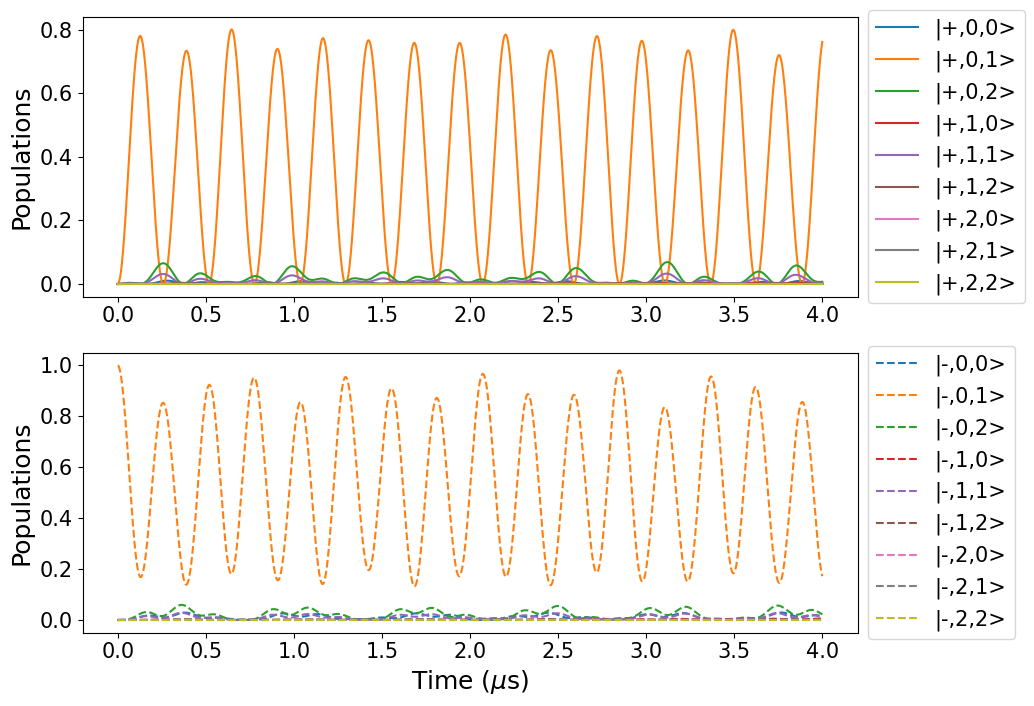

In [ ]:
data = qload(states_filename)
plot_populations_plus_minus(data, figname = 'test')
plt.show()

Makes sense as \chi * alpha^2 is doing - + rotations at 5 Mhz ( faster than swap rate of 1 Mhz)

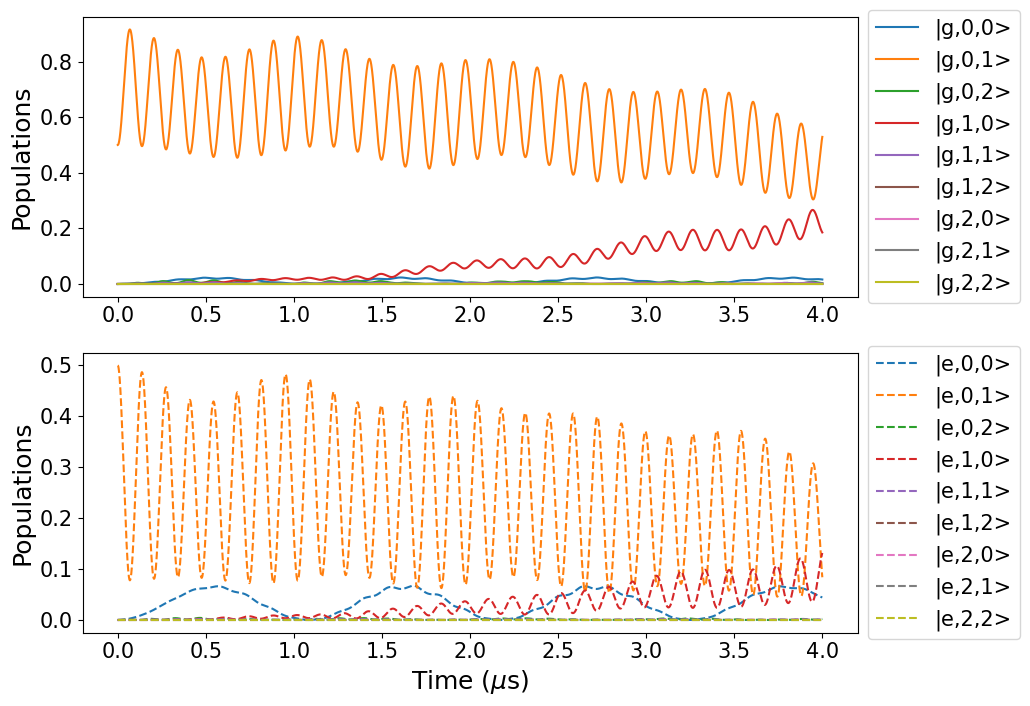

In [ ]:
# data = qload(states_filename)
# plot_populations(data, figname = 'test')
# plt.show()

Removing the ACStark shift-1* chi1 * alpha1 * alpha1 * tensor(sigmaz(), identity_c, identity_c)

In [ ]:
H0 = (del_c1*tensor(identity_q, num_c, identity_c) +
      del_c2*tensor(identity_q, identity_c, num_c) +
      
      +1* Omega_q * tensor(sigmax(), identity_c, identity_c)/2   + 
      -1* chi1 * alpha1 * tensor(sigmaz(), a_c + adag_c, identity_c) +   # cpnd disp
      -1* chi2 * alpha2 * tensor(sigmaz(), identity_c, a_c + adag_c)
      
      -1* chi1 * alpha1 * tensor(sigmaz(), num_c, identity_c) # dispersive interaction
      -1* chi2 * alpha2 * tensor(sigmaz(), identity_c, num_c)
      
      #-1* chi1 * alpha1 * alpha1 * tensor(sigmaz(), identity_c, identity_c) # AC stark shifts
      #-1* chi2 * alpha2 * alpha2 * tensor(sigmaz(), identity_c, identity_c)
     )
     
cos1 = np.array([np.cos(del_c1 * t) for t in times])
cos2 = np.array([np.cos(del_c2 * t) for t in times])

H = [H0, 
    #[ 2*chi1 * alpha1 * tensor(sigmax(), a_c + adag_c, identity_c), cos1], 
     # [2*chi2 * alpha2 * tensor(sigmax(), identity_c, a_c + adag_c), cos2]
    ]
c_ops = []

In [ ]:
plus = (basis(n_q, 0 ) + basis(n_q, 1)) / np.sqrt(2)
plus = (basis(n_q, 0 ) + basis(n_q, 1)) / np.sqrt(2)
minus = (basis(n_q, 0 ) - basis(n_q, 1)) / np.sqrt(2)
e_state = basis(n_q, 1)
g_state = basis(n_q, 0)

psi0 = tensor(minus, basis(n_c,0), basis(n_c, 1))
opts = Options(store_states=True, store_final_state=True, nsteps = 10000)
output = mesolve(H, psi0 , times, c_ops, [], options =opts)
states_filename = 'State_store_g0_g1_disp'
qsave(output.states, states_filename)
rho = output.states[-1]

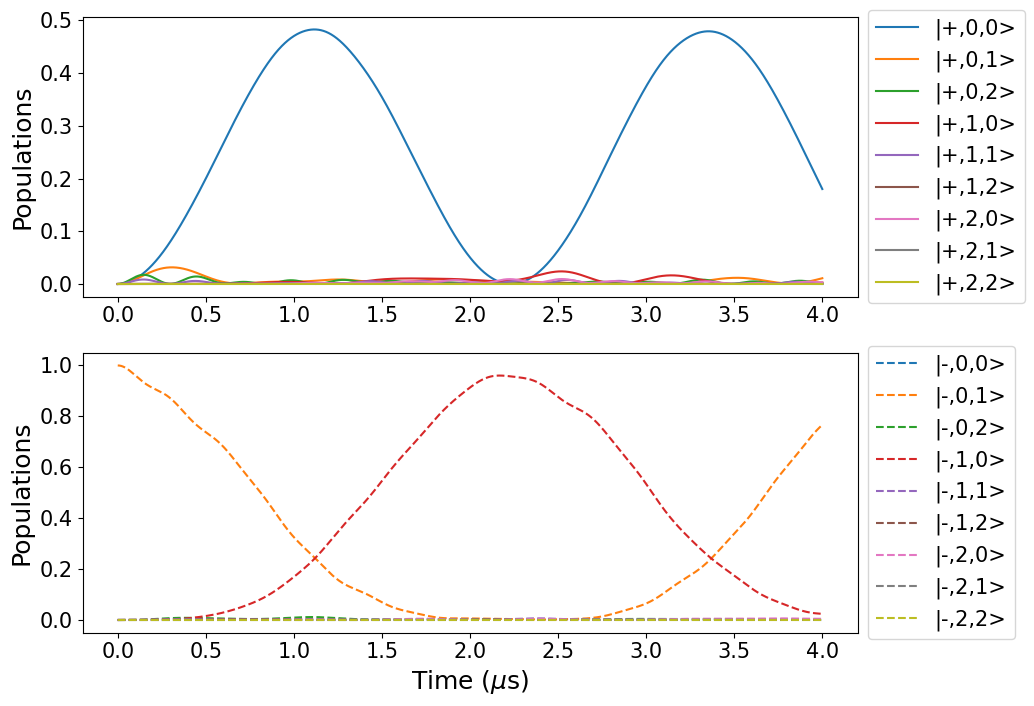

In [ ]:
data = qload(states_filename)
plot_populations_plus_minus(data, figname = 'test')
plt.show()

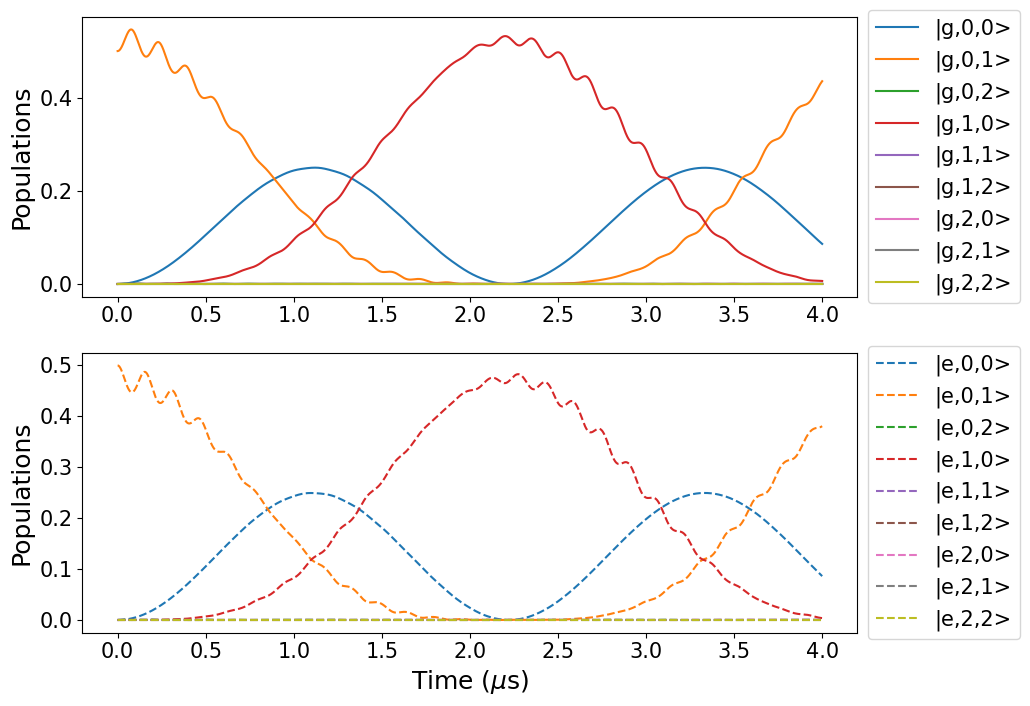

In [ ]:
# data = qload(states_filename)
# plot_populations(data, figname = 'test')
# plt.show()

In [ ]:
times = np.linspace(0, 8000, 2000)

In [ ]:
H0 = (del_c1*tensor(identity_q, num_c, identity_c) +
      del_c2*tensor(identity_q, identity_c, num_c) +
      
      -1* Omega_q * tensor(sigmaz(), identity_c, identity_c)/2   + 
      chi1 * alpha1 * tensor(sigmax(), a_c + adag_c, identity_c) +
      chi2 * alpha2 * tensor(sigmax(), identity_c, a_c + adag_c)
     )
     
cos1 = np.array([np.cos(del_c1 * t) for t in times])
cos2 = np.array([np.cos(del_c2 * t) for t in times])

H = [H0, 
    #[ 2*chi1 * alpha1 * tensor(sigmax(), a_c + adag_c, identity_c), cos1], 
     # [2*chi2 * alpha2 * tensor(sigmax(), identity_c, a_c + adag_c), cos2]
    ]
c_ops = []

In [ ]:
plus = (basis(n_q, 0 ) + basis(n_q, 1)) / np.sqrt(2)
plus = (basis(n_q, 0 ) + basis(n_q, 1)) / np.sqrt(2)
minus = (basis(n_q, 0 ) - basis(n_q, 1)) / np.sqrt(2)
e_state = basis(n_q, 1)
g_state = basis(n_q, 0)

psi0 = tensor(g_state, basis(n_c,0), basis(n_c, 1))
opts = Options(store_states=True, store_final_state=True, nsteps = 10000)
output = mesolve(H, psi0 , times, c_ops, [], options =opts)
states_filename = 'State_store_g0_g1_disp'
qsave(output.states, states_filename)
rho = output.states[-1]

C:\Users\Eesh Gupta\anaconda\lib\site-packages\matplotlib\cbook\__init__.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


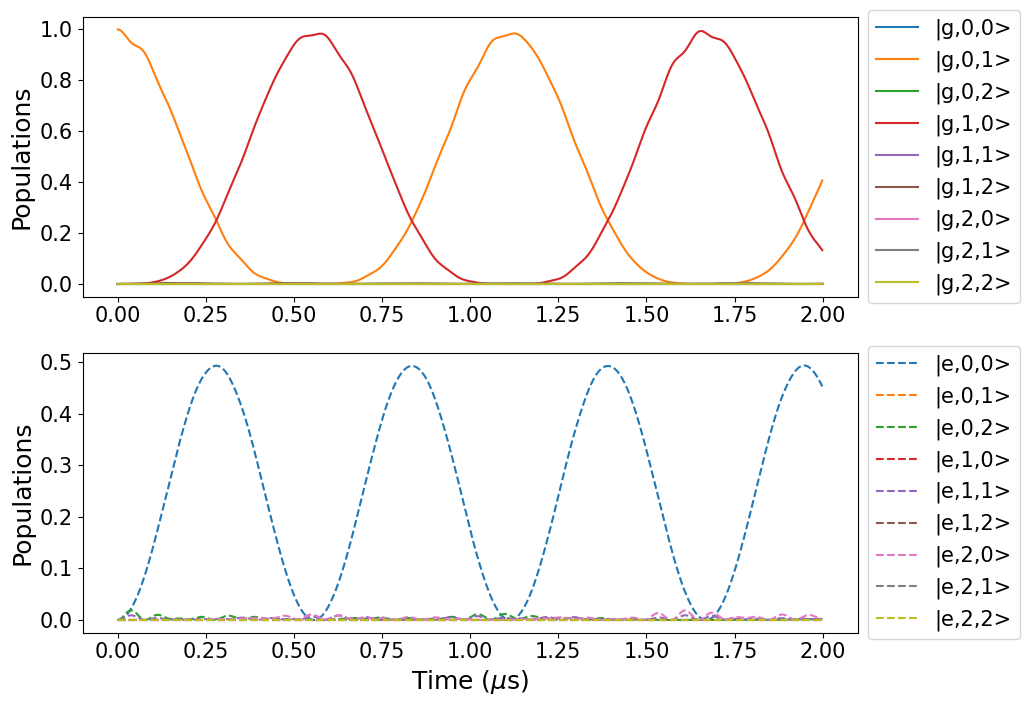

In [ ]:
data = qload(states_filename)
plot_populations(data, figname = 'test')
plt.show()